# Table of Contents
* [Load Packages and Data](#Load-Packages-and-Data)
* [Topic Modeling](#Topic-Modeling) 
    * [Build LDA Model with sklearn](#Build-LDA-Model-with-sklearn)
        * [Clean-up Review Text](#Clean-up-Review-Text)
        * [Create the Document-Word Matrix](#Create-the-Document-Word-Matrix)
        * [LDA Model](#LDA-Model)
        * [Dominant Topic in each Document](#Dominant-Topic-in-each-Document)
        * [Visualize the LDA Model with pyLDAvis](#Visualize-the-LDA-Model-with-pyLDAvis)        
    * [Build LDA Model with Gensim](#Build-LDA-Model-with-Gensim)
        * [Create the Dictionary and Corpus Needed for Topic Modeling](#Create-the-Dictionary-and-Corpus-Needed-for-Topic-Modeling)
        * [Model Perplexity](#Model-Perplexity)
        * [Visualize Topics with pyLDAvis](#Visualize-Topics-with-pyLDAvis)
        * [Test on Holdout data](#Test-on-Holdout-data)
* [Build Machine Learning Models for Prediction](#Build-Machine-Learning-Models-for-Prediction)
    * [Create a Target Column](#Create-a-Target-Column)
        * [t-test of the Character Length of Reviews](#t-test-of-the-Character-Length-of-Reviews)
    * [Build a Pipeline](#Build-a-Pipeline)
        * [Encoding the Categorical Target Feature](#Encoding-the-Categorical-Target-Feature)
    * [Use bag-of-word Features for Prediction](#Use-bag-of-word-Features-for-Prediction)
        * [Grid Search Hyperparameter](#Grid-Search-Hyperparameter)
        * [Strongly Predictive Features](#Strongly-Predictive-Features)
    * [Use Tfidf-weighted Features for Prediction](#Use-Tfidf-weighted-Features-for-Prediction)
        * [Feed Less TfidfVectorized Features to Classifier](#Feed-Less-TfidfVectorized-Features-to-Classifier)
    * [Use sklearn LDA Document Topics for Prediction](#Use-sklearn-LDA-Document-Topics-for-Prediction)
    * [Use Gensim LDA Document Topics for Prediction](#Use-Gensim-LDA-Document-Topics-for-Prediction)
    * [Compare Model Performance](#Compare-Model-Performance)
* [Improve Model Performance](#Improve-Model-Performance)
    * [Poor or not](#Poor-or-not)
    * [Enrich Predictors with Categorical and Numerical Features](#Enrich-Predictors-with-Categorical-and-Numerical-Features)
        * [Improved Model Performance](#Improved-Model-Performance)
    

# Load Packages and Data 
This is the second part of the capstone project that investigates reviews dataset of hotels. It focuses on wrangling the text data and uses word features to train a machine learning classifier for hotel classification based on the review texts. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

#manipulate and view data in tabular format
import pandas as pd
import numpy as np
import pickle 
#process text
import re,nltk,spacy,gensim
from gensim.models import CoherenceModel
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

 #visualization tools
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

#seaborn
import seaborn as sns
sns.set(context='paper',style='whitegrid',font_scale=2, rc={"lines.linewidth": 2.5})#style=whitegrid,darkgrid,white,dark
pd.set_option('display.max_columns', None)


#LDA visualzation
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim




#sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer, Imputer, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint #Data pretty printer
from sklearn.feature_selection import SelectKBest,chi2




Using TensorFlow backend.


We've cleaned the raw hotel data as reported in the [milestone report](https://github.com/phyhouhou/SpringboardProjects/blob/master/SecondCapstoneProject/2ndCapstoneProject_MilestoneReport/2ndCapstoneProject_Milestone.ipynb) by handling missing values, drop duplilcates and cleaning and enriching features. Here we load the cleaned hotel data for analysis and focus on the review texts.

In [2]:
data=pd.read_csv('data/htl_clean.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515212 entries, 0 to 515211
Data columns (total 24 columns):
Review_Date                                   515212 non-null object
Review_Month                                  515212 non-null object
Review_Wday                                   515212 non-null object
Hotel_Name                                    515212 non-null object
Hotel_Address                                 515212 non-null object
Hotel_City                                    515212 non-null object
lat                                           511944 non-null float64
lng                                           511944 non-null float64
Average_Score                                 515212 non-null float64
Total_Number_of_Reviews                       515212 non-null int64
Reviewer_Nationality                          515212 non-null object
Total_Number_of_Reviews_Reviewer_Has_Given    515212 non-null int64
Reviewer_Score                                515212 non-nul

,Review_Date,Review_Month,Review_Wday,Hotel_Name,Hotel_Address,Hotel_City,lat,lng,Average_Score,Total_Number_of_Reviews,Reviewer_Nationality,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Negative_Review,Review_Total_Negative_Word_Counts,Neg_Rev_WCRatio,Positive_Review,Review_Total_Positive_Word_Counts,Pos_Rev_WCRatio,Trip_Type,Traveler_Type,Num_Nights,Additional_Number_of_Scoring,days_since_review
0,2017-08-03,Aug,Thu,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,Russia,7,2.9,I am so angry that i made this post available...,397,0.973039,Only the park outside of the hotel was beauti...,11,0.026961,Leisure trip,Couple,6.0,194,0
1,2017-08-03,Aug,Thu,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,Ireland,7,7.5,No Negative,0,0.000000,No real complaints the hotel was great great ...,105,1.000000,Leisure trip,Couple,4.0,194,0
2,2017-07-31,Jul,Mon,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,Australia,9,7.1,Rooms are nice but for elderly a bit difficul...,42,0.666667,Location was good and staff were ok It is cut...,21,0.333333,Leisure trip,Family with young children,3.0,194,3
3,2017-07-31,Jul,Mon,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,United Kingdom,1,3.8,My room was dirty and I was afraid to walk ba...,210,0.889831,Great location in nice surroundings the bar a...,26,0.110169,Leisure trip,Solo traveler,3.0,194,3
4,2017-07-24,Jul,Mon,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,New Zealand,3,6.7,You When I booked with your company on line y...,140,0.945946,Amazing location and building Romantic setting,8,0.054054,Leisure trip,Couple,2.0,194,10


# Topic Modeling 

## Build LDA Model with sklearn
The aim  of topic modeling is to extract hidden topics from a large volume of texts and LDA is a popular algorithm for topic modeling. In this section, we will first clean the texts and then create a word-document matrix, which is a required input for implementing the LDA algorithm with sklearn. We will then build a LDA model and discuss the model performance to find out what topics reviewers are talking about. 

### Clean-up Review Text 

Review texts will be processed in the following steps:

* Remove short reviews
* Remove all non-letters characters;
* Strip whitespaces;
* Tokenize sentence into a list of words;
* Remove English stopwords;
* Lemmatize words to its roots.

Then we will save the cleaned review texts in a csv file for future analysis.

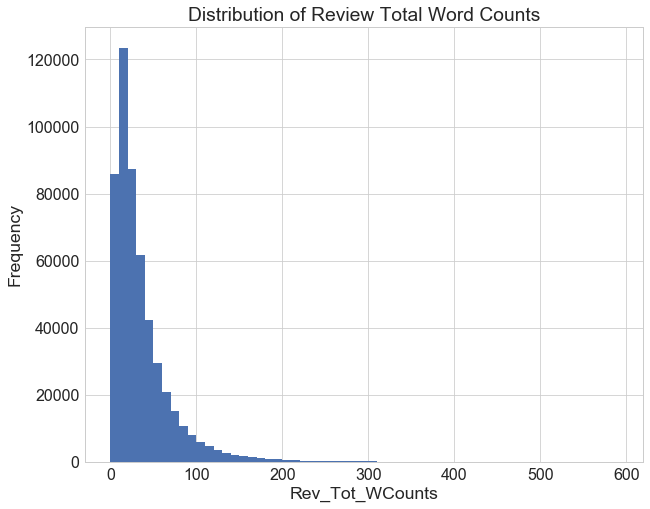

In [4]:
Rev_Tot_WCounts=data['Review_Total_Positive_Word_Counts']+data['Review_Total_Negative_Word_Counts']

plt.hist(Rev_Tot_WCounts,bins=np.arange(0,600,10))
plt.xlabel('Rev_Tot_WCounts')
plt.ylabel('Frequency')
plt.title('Distribution of Review Total Word Counts');



In [5]:
# Set for the total word count of a review a threshold below which reviews will be removed 
thresh=10
idx=Rev_Tot_WCounts<thresh
#len(data[idx])/len(data), len(data[~idx])


# Reorganize columns
categories=['Review_Month','Hotel_City','Reviewer_Nationality','Trip_Type','Traveler_Type']
numerics=['Total_Number_of_Reviews_Reviewer_Has_Given','Review_Total_Positive_Word_Counts',
          'Review_Total_Negative_Word_Counts','Num_Nights']
text=['Negative_Review','Positive_Review']
cols=categories+text+['Reviewer_Score']
df=data[~idx][cols]


df.Negative_Review.replace('No Negative', ' ',inplace=True)
df.Positive_Review.replace('No Positive', ' ',inplace=True)

# Combine positive and negative reviews
Full_Review=df.Negative_Review+' '+df.Positive_Review
for num,message in enumerate(Full_Review.head(10)):
    print(num,message)
    print ('\n')


0  I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings The room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it I intimately asked to change the room and after explaining 2 times that i booked a duplex btw it costs the same as a simple double but got way more volume due to the high ceiling was offered a room but only the next day SO i had to check out the next day before 11 o clock in order to get the room i waned to Not the best way to begin 

In [ ]:
# Caution: very time-consuming. We've saved the lemmatized reviews in a csv file


#---------Prepare the review text column--------
def prepare_txt(txts): #txts=df[txt_col]
    # Convert reviews to a list
    texts=txts.values.tolist()
    
    # Remove non-letter characters
    texts=[re.sub('[^a-zA-Z]',' ', t) for t in texts]
    
    # Strip whitespaces
    texts=[t.strip() for t in texts]
    
    return texts
   
#----------Remove Stopwords-----------------   
#Prepare NLTK stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['hotel'])

# Tokenize and Remove stopwords
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


#-----------Lemmatization------------------
import warnings
warnings.filterwarnings('ignore')

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation. All pronouns are lemmatized to the special token -PRON-"""
    texts_lemma = []
    for w in texts:
        doc = nlp(' '.join(w)) 
        texts_lemma.append(' '.join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_lemma


# Do lemmatization keeping only Noun, Adj, Verb, Adverb
neg_reviews=remove_stopwords(prepare_txt(df['Negative_Review']))
pos_reviews=remove_stopwords(prepare_txt(df['Positive_Review']))


neg_rev_lemmatized = lemmatization(neg_reviews, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
pos_rev_lemmatized = lemmatization(pos_reviews, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



# Save the lemmatized reviews
df['Neg_Rev_Lemmatized']=neg_rev_lemmatized
df['Pos_Rev_Lemmatized']=pos_rev_lemmatized


df.to_csv('data/htl_rev_lem_added.csv',index=False) 

**Load Cleaned Data**

In [6]:
#Load cleaned data
df_txt=pd.read_csv('data/htl_rev_lem_added.csv')

# Join negative and positive reviews
df_txt['Rev_Lemmatized']=df_txt['Neg_Rev_Lemmatized'].fillna('')+' '+df_txt['Pos_Rev_Lemmatized'].fillna('')

df_txt.head()

,Review_Month,Hotel_City,Reviewer_Nationality,Trip_Type,Traveler_Type,Negative_Review,Positive_Review,Reviewer_Score,Neg_Rev_Lemmatized,Pos_Rev_Lemmatized,Rev_Lemmatized
0,Aug,Amsterdam,Russia,Leisure trip,Couple,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,2.9,angry make post available possible site use pl...,park beautiful,angry make post available possible site use pl...
1,Aug,Amsterdam,Ireland,Leisure trip,Couple,,No real complaints the hotel was great great ...,7.5,NaN,real complaint great great location surroundin...,real complaint great great location surroundi...
2,Jul,Amsterdam,Australia,Leisure trip,Family with young children,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,7.1,room nice elderly bit difficult room story nar...,location good staff cute breakfast range nice ...,room nice elderly bit difficult room story nar...
3,Jul,Amsterdam,United Kingdom,Leisure trip,Solo traveler,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,3.8,room dirty afraid walk barefoot floor look cle...,great location nice surrounding bar restaurant...,room dirty afraid walk barefoot floor look cle...
4,Jul,Amsterdam,New Zealand,Leisure trip,Couple,You When I booked with your company on line y...,Amazing location and building Romantic setting,6.7,book company line show picture room think get ...,amazing location build romantic setting,book company line show picture room think get ...


In [7]:
print('Number of non-null Negative_Review: %d' %len(df_txt.Neg_Rev_Lemmatized.dropna()))
print('Number of non-null Positive_Review: %d' %len(df_txt.Pos_Rev_Lemmatized.dropna()))
print('Number of Observations: %d' %len(df_txt))

Number of non-null Negative_Review: 343488
Number of non-null Positive_Review: 405189
Number of Observations: 429464


### Create the Document-Word Matrix 
We create the document-word matrix by using CountVectorizer as the main input of the LDA topic model. Since the review data is very large, we only consider words that has occurred at at least 10 times (min_df) and with at least character length 3 , remove built-in english stopwords and convert all words to lowercase.

In [8]:
# Joined negative and positive reviews
rev_lemmatized=df_txt['Rev_Lemmatized']

# Initialise the CountVectorizer with the required configuration
c_vec = CountVectorizer(analyzer='word',       
                             min_df=10,                       
                             stop_words='english',             
                             lowercase=True,                  
                             token_pattern='[a-zA-Z]{3,}',    # num chars > 3 
                             #max_features=10000             # max number of unique words
                            )

# Build the vocabulary by 'fit'
c_vec.fit(rev_lemmatized)

# Convert reviews to a bag of words
rev_vectorized=c_vec.transform(rev_lemmatized) 

In [9]:
# Check the sparscity, i.e., percentage of Non-Zero cells
print ('Shape of Sparse Matrix: ', rev_vectorized.shape)
print ('Amount of Non-Zero occurences: ', rev_vectorized.nnz)
print ('sparsity: %.2f%%' % (100.0 * rev_vectorized.nnz / (rev_vectorized.shape[0] * rev_vectorized.shape[1])))

Shape of Sparse Matrix:  (429464, 10670)
Amount of Non-Zero occurences:  6941938
sparsity: 0.15%


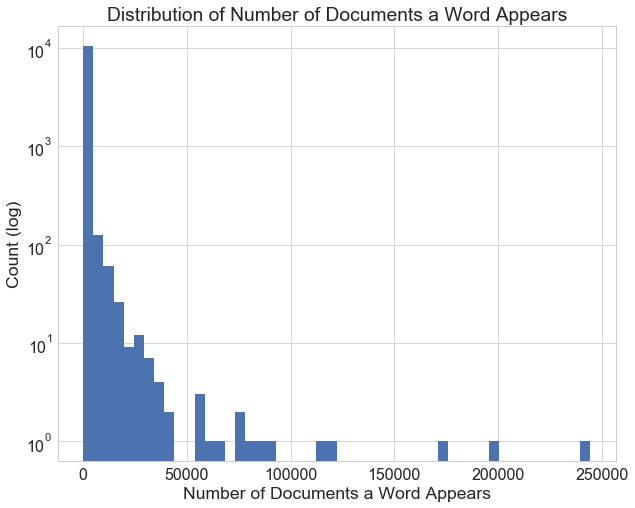

In [10]:
#Calculate 'count' as the number of documents that a word appears 
count=(rev_vectorized>0).sum(axis=0).A.tolist()[0]#count as 1 if the word appear in a document regardless how many times it appear
plt.hist(count,bins=50,log=True)
plt.xlabel('Number of Documents a Word Appears')
plt.ylabel('Count (log)')
plt.title('Distribution of Number of Documents a Word Appears');

The distribution is very long-tailed. Some of the words appear in too many documents.

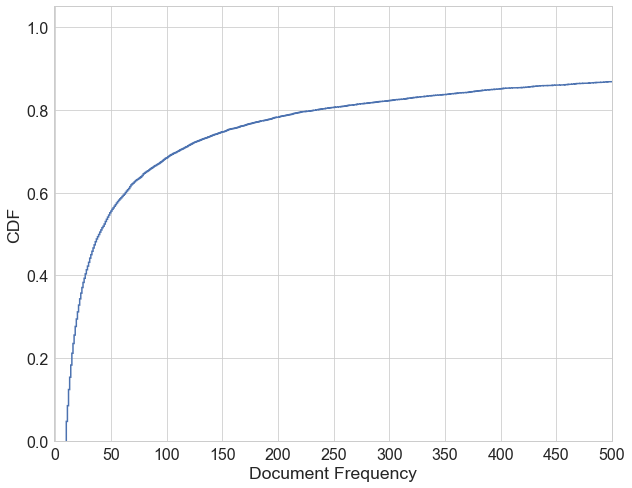

In [11]:
#Construct the cumulative distribution of document frequencies (df)
plt.hist(count,bins=np.unique(count),cumulative=True,density=True,histtype='step',linewidth=1.5);
plt.xlabel('Document Frequency')
plt.ylabel('CDF')
plt.xticks(np.arange(0,501,50))
plt.xlim(-1,500);



This CDF plot justified us in setting 'min_df'=10 around which the curve starts to climb steeply.

In [12]:
# Word feature in each column of the transformed matrix
wfeatures=c_vec.get_feature_names()
print("Lengh of features:",len(wfeatures))

Lengh of features: 10670


In [13]:
# Word and its count
d=dict(zip(wfeatures, np.ravel(rev_vectorized.sum(axis=0))))
print('\n Top 10 Features in the bag-of-word and the counts:\n')
pd.DataFrame(sorted(d.items(),key=lambda x: x[1],reverse=True)[:10],columns=['word','count'])


 Top 10 Features in the bag-of-word and the counts:



,word,count
0,room,376243
1,staff,218196
2,location,178012
3,good,145318
4,breakfast,135939
5,great,106319
6,bed,97308
7,friendly,83682
8,clean,81072
9,helpful,76320


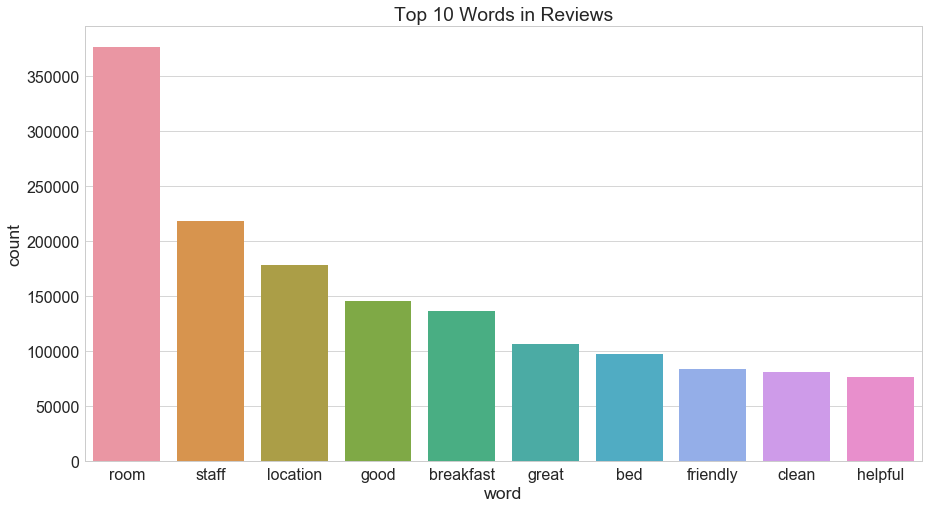

In [14]:
# Visualize counts of words
d=dict(zip(wfeatures, np.ravel(rev_vectorized.sum(axis=0))))
w_c=pd.DataFrame.from_dict((d),orient='index').reset_index()
w_c.columns=('word','count')
w_c=w_c.sort_values(by='count',ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(x='word', y='count', data=w_c.head(10).sort_values('count',ascending=False))            
plt.title("Top 10 Words in Reviews");

### LDA Model 

The reviews have both negative and positive part. Will the model be able to separate reviews into positive and negative ones? Since topic-modeling can be quite time-consuming and the data is quite large, let's build a 2-topic model to explore this issue. 

In [15]:
 for num,message in enumerate(rev_lemmatized[:10]):
    print(num,message)
    print ('\n')

0 angry make post available possible site use plan trip make mistake book place make booking book com stay night arrival place small room floor turn room book specially reserve level duplex room would big window high ceiling room mind break window close hello rain mini fridge contain sort bio weapon least guess smell intimately ask change room explain time book duplex btw cost simple double get way volume due high ceiling offer room next day check next day clock order get room wan good way begin holiday wait order check new room wonderful waist time room get want peaceful internal garden view big window tired waiting room place belonging rush city evening turn constant noise room guess make vibrate vent tube something constant annoying hell stop even make hard fall asleep wife audio recording attach want send mail next day technician come able determine because disturb sound offer change room fully book room leave small seem new park beautiful


1  real complaint great great location s

In [16]:
lda_modeln2 = LDA(n_components=2,          
                  max_iter=10, # default max learning iterations: 10. with the sample, this code takes mins
                  learning_method='online',   
                  random_state=100,          # Random state
                  batch_size=128,            # default num docs in each learning iter
                  evaluate_every = 0,       # compute perplexity every n iters, default: Don't
                  n_jobs =1,               # Dont't use all available CPUs
                  )

lda_modeln2.fit(rev_vectorized)
lda_output = lda_modeln2.transform(rev_vectorized)

lda_n2_LogLikelihood=lda_modeln2.score(rev_vectorized)
lda_n2_perp=lda_modeln2.perplexity(rev_vectorized)

In [17]:
# See model parameters
print('Model parameters:')
pprint(lda_modeln2.get_params())

#----Diagnose model performance with perplexity and log-likelihood---
# Log Likelyhood: Higher the better
print("\nLog Likelihood Score: %.2f" %lda_n2_LogLikelihood) 

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("\nPerplexity: %.2f" %lda_n2_perp) 



Model parameters:
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': 0,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 2,
 'n_jobs': 1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}

Log Likelihood Score: -49818074.95

Perplexity: 703.10


In [18]:
# Define a function to display topics
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 20
feature_names=c_vec.get_feature_names()
display_topics(lda_modeln2, feature_names, num_top_words)

Topic 0:
room bed staff night good shower check breakfast day bathroom location time work small reception stay make book floor ask
Topic 1:
staff room location good breakfast great friendly helpful nice clean excellent comfortable bed stay close restaurant station walk really lovely


Topics are quite overlapped for n_component=2 model and the model doesn't seem to classify reviews as negative and positive topics as obviously as expected. In both topics 'small' is used, the main contents are positive. 

Since we have limited computing resources and it takes several hours to run the LDA code with original data, we pick n_components=5 for display with the sampled data (several miniutes). We will compare accuracy score in machine learning part for larger n_components=5,50,100 to analyze how n_components affects the model performance.

In [19]:

lda_modeln5 = LDA(n_components=5,          
                  max_iter=10, # default max learning iterations: 10. takes 3mins
                  learning_method='online',   
                  random_state=100,          # Random state
                  batch_size=128,            # default num docs in each learning iter
                  evaluate_every = 0,       # compute perplexity every n iters, default: Don't
                  n_jobs =1,               # Don't use all available CPUs
                  )
lda_modeln5.fit(rev_vectorized)
lda_output = lda_modeln5.transform(rev_vectorized)



In [20]:
lda_n5_LogLikelihood=lda_modeln5.score(rev_vectorized)
lda_n5_perp=lda_modeln5.perplexity(rev_vectorized)

#----Diagnose model performance with perplexity and log-likelihood---
# Log Likelyhood: Higher the better
print("\nLog Likelihood Score: %.2f" %lda_n5_LogLikelihood) 

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("\nPerplexity: %.2f" %lda_n5_perp) 




Log Likelihood Score: -50135369.38

Perplexity: 733.08


In [21]:
# Save model using pickle
filename = 'lda_modeln5.sav'
pickle.dump(lda_modeln5, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
lda_modeln5 = pickle.load(open(filename, 'rb'))

In [ ]:
# # GridSearch will Take several hours
# import warnings
# warnings.filterwarnings('ignore')


# # Define Search Param
# search_params = {'n_components': [5, 50, 100]}

# # Init the Model
# lda = LDA(n_jobs=1,random_state=100)

# # Init Grid Search Class
# model = GridSearchCV(lda, param_grid=search_params) 

# # Do the Grid Search
# model.fit(rev_vectorized)

# # Show the best topic model and its parameters

# # Best Model
# best_lda_model = model.best_estimator_

# # Model Parameters
# print("Best Model's Params: ", model.best_params_)

# # Log Likelihood Score
# print("Best Log Likelihood Score: %.2f" %(model.best_score_))

# # Perplexity
# print("Model Perplexity: %.2f" %( best_lda_model.perplexity(rev_vectorized)))


# #Save the best_lda_model

# # # Save model using pickle
# filename = 'best_lda.sav'
# pickle.dump(best_lda_model, open(filename, 'wb'))
 
# # some time later...
 
# # load the model from disk
# best_lda_model = pickle.load(open(filename, 'rb'))

### Dominant Topic in each Document

What particular topic does a document belong to? A dominant topic in a document is spotted by finding the topic that has the highest contributions (revealed by the document-topic matrix) to that document. We will first display top 20 keywords in all the topics and then make a table to show all major topics in a document and specify the most dominant topic in that document.

#### Display keywords in topics

In [22]:
num_top_words = 20
feature_names=c_vec.get_feature_names()
print('Top 20 Words in topics found in the 5-topic lda_model')
display_topics(lda_modeln5, feature_names, num_top_words)

Top 20 Words in topics found in the 5-topic lda_model
Topic 0:
bed room bathroom shower comfortable small comfy clean nice water good location pillow big bath size great coffee double large
Topic 1:
staff breakfast room location friendly helpful good great excellent clean nice bar food comfortable service lovely really restaurant facility stay
Topic 2:
location close walk station good great city metro nice restaurant pool minute easy room area clean train centre value parking
Topic 3:
stay staff check room time day book make pay ask service reception night say charge come tell help leave extra
Topic 4:
room location good work night breakfast floor window air door noise star open noisy small old bad need clean poor


Topic 0 mentioned 'room', 'staff', 'reception', 'service', 'work'.<br>
Topic 1 mentioned quite a few negative aspects, 'small', 'old', 'dirty'.<br>
Topic 2 talks about 'room', 'bathroom', 'noise',' pool', 'bar'.<br>
Topic 3 talks about 'room', 'staff', 'location', 'breakfast' 'bar 'and 'restaurant'.<br>
Topic 4 talks about service, parking etc.<br>

#### Make a  Document - Topic Table 

In [23]:
# Create Document - Topic Matrix
lda_output=lda_modeln5.transform(rev_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_modeln5.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df_txt))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topics = df_document_topic.head(10)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.03,0.00,0.07,0.47,0.43,3
Doc1,0.12,0.45,0.11,0.32,0.00,1
Doc2,0.20,0.41,0.01,0.12,0.26,1
Doc3,0.08,0.00,0.06,0.25,0.60,4
Doc4,0.00,0.00,0.06,0.68,0.26,3
Doc5,0.01,0.38,0.30,0.16,0.14,1
Doc6,0.89,0.01,0.08,0.01,0.01,0
Doc7,0.01,0.88,0.09,0.01,0.01,1
Doc8,0.22,0.02,0.02,0.34,0.41,4
Doc9,0.27,0.22,0.25,0.01,0.26,0


#### Visualize topics distribution across documents

In [24]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num_Documents")
df_topic_distribution.columns = ['Topic', 'Num_Documents']
df_topic_distribution

,Topic,Num_Documents
0,1,153341
1,2,78369
2,3,75114
3,4,65793
4,0,56847


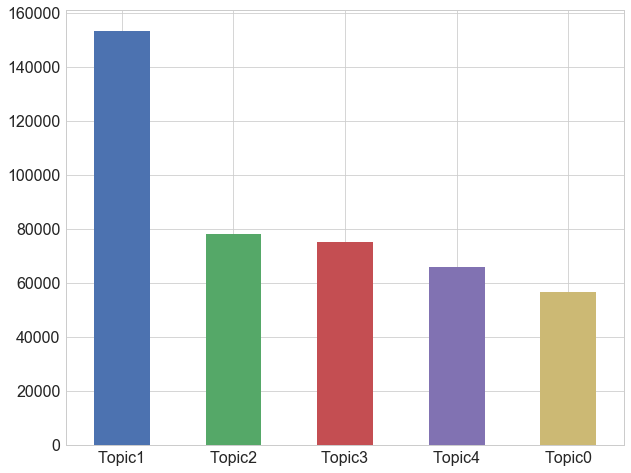

In [25]:
# Visualize the topic distributions across sampled documents
df_topic_distribution['Num_Documents'].plot(kind='bar',rot=0)
plt.xticks(np.arange(0,5),'Topic'+df_topic_distribution['Topic'].astype('str'));

Most of the documents in our sample seems to about topic 3. 

### Visualize the LDA Model with pyLDAvis 

In [26]:
pyLDAvis.enable_notebook()
lda_display_sk= pyLDAvis.sklearn.prepare(lda_modeln5, rev_vectorized, c_vec, mds='tsne')
lda_display_sk

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      24.981592        1       1  151.945648 -108.520294
3      22.721737        1       2  -25.139259 -175.862152
4      18.682259        1       3   57.242630   -5.324613
2      18.410679        1       4   97.995369 -243.457733
0      15.203733        1       5  -81.867287  -47.350636, topic_info=      Category           Freq         Term          Total  loglift  logprob
term                                                                       
843    Default   98758.000000          bed   98758.000000  30.0000  30.0000
8900   Default  211354.000000        staff  211354.000000  29.0000  29.0000
3879   Default   80403.000000     friendly   80403.000000  28.0000  28.0000
8008   Default  369911.000000         room  369911.000000  27.0000  27.0000
4427   Default   74356.000000      helpful   74356.000000  26.0000  26.0000
1137   Default  140570.000000    breakfast  140570.000000  25.0000  25.0000
8456   Default   35152.000000       shower   35152.000000  24.0000  24.0000
795    Default   45774.000000     bathroom   45774.000000  23.0000  23.0000
10345  Default   36392.000000         walk   36392.000000  22.0000  22.0000
8956   Default   36350.000000      station   36350.000000  21.0000  21.0000
4192   Default  104244.000000        great  104244.000000  20.0000  20.0000
1764   Default   40649.000000        close   40649.000000  19.0000  19.0000
5462   Default  173833.000000     location  173833.000000  18.0000  18.0000
3354   Default   57183.000000    excellent   57183.000000  17.0000  17.0000
1571   Default   33777.000000        check   33777.000000  16.0000  16.0000
10581  Default   27482.000000         work   27482.000000  15.0000  15.0000
1876   Default   61678.000000  comfortable   61678.000000  14.0000  14.0000
1674   Default   25840.000000         city   25840.000000  13.0000  13.0000
4113   Default  147976.000000         good  147976.000000  12.0000  12.0000
1884   Default   20165.000000        comfy   20165.000000  11.0000  11.0000
3762   Default   27087.000000         food   27087.000000  10.0000  10.0000
8961   Default   66914.000000         stay   66914.000000   9.0000   9.0000
5861   Default   21424.000000        metro   21424.000000   8.0000   8.0000
1046   Default   24008.000000         book   24008.000000   7.0000   7.0000
8616   Default   54293.000000        small   54293.000000   6.0000   6.0000
8340   Default   43905.000000      service   43905.000000   5.0000   5.0000
7844   Default   37157.000000   restaurant   37157.000000   4.0000   4.0000
10534  Default   18126.000000       window   18126.000000   3.0000   3.0000
2444   Default   34023.000000          day   34023.000000   2.0000   2.0000
9560   Default   36149.000000         time   36149.000000   1.0000   1.0000
...        ...            ...          ...            ...      ...      ...
9787    Topic5    1995.888008          tub    1996.688074   1.8832  -6.3611
10367   Topic5    1790.038994     wardrobe    1790.837398   1.8832  -6.4700
8529    Topic5    3379.166500         sink    3382.014321   1.8828  -5.8346
8528    Topic5    7630.133947       single    7739.590833   1.8694  -5.0201
795     Topic5   37730.957948     bathroom   45774.372988   1.6904  -3.4217
2904    Topic5   10112.959433       double   11828.225315   1.7270  -4.7384
8758    Topic5    8440.622856        space   10149.448024   1.6993  -4.9191
4345    Topic5    6878.666565         hard    8058.074918   1.7254  -5.1238
10398   Topic5   14479.767964        water   19713.550762   1.5751  -4.3794
5126    Topic5    3565.674490       kettle    3994.362312   1.7701  -5.7808
8547    Topic5   10426.377389         size   15936.321910   1.4594  -4.7079
5237    Topic5    9697.799687        large   14966.263537   1.4497  -4.7803
8616    Topic5   25807.405112        small   54293.192921   1.1399  -3.8015
1876    Topic5   27137.080615  comfortable   61678.0614

![title](img/ldavis_skn5.png)
For an interactive visualization, click [here](https://)

## Build LDA Model with Gensim
Since the LDA model with sklearn takes lots of computing resources for larger number of topics. We turn to gensim for building the LDA model. For gensim we need to tokenize the data and filter out stopwords. 

### Create the Dictionary and Corpus Needed for Topic Modeling
Since the size of reviews is quite large, we randomly select some samples to train the model. We can evaluate our topic models by the holdout test set.

In [27]:
from sklearn.model_selection import train_test_split

# small samples for test
#dft=df_txt.sample(50,random_state=100)
#itrain, itest = train_test_split(range(dft.shape[0]), train_size=0.7,random_state=100)
#mask = np.zeros(dft.shape[0], dtype=np.bool)
#mask[itrain] = True
#rev_gens=dft['Rev_Lemmatized'][mask]

itrain, itest = train_test_split(range(df_txt.shape[0]), train_size=0.7,random_state=100)
mask = np.zeros(df_txt.shape[0], dtype=np.bool)
mask[itrain] = True

rev_gens=df_txt['Rev_Lemmatized'][mask]



In [31]:
#Prepare NLTK stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['hotel'])



# Tokenize and clean sentences to words 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations



def process_text(sentences):
    # Create Corpus
    txt_tokenized=list(sent_to_words(sentences))
    # Remove stopwords
    txt_tokenized = [[w for w in doc if w not in stop_words] for doc in txt_tokenized]
    return txt_tokenized


import warnings
warnings.filterwarnings('ignore')


rev_tokenized=process_text(rev_gens)
    # Create Dictionary-association word to numericID
dictionary = gensim.corpora.Dictionary(rev_tokenized )
    # Term Document Frequency-transform collections of texts to numeric form
corpus = [dictionary.doc2bow(txt) for txt in rev_tokenized ]

    # #View the first document:[(word_id,count ),()...]
print(corpus[:1])


    #save dictionary and corpus
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

[[(0, 1), (1, 5), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 5), (11, 3), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 13), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 2), (27, 3), (28, 2), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 3), (54, 2), (55, 1), (56, 1), (57, 2), (58, 3), (59, 3), (60, 2), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1

In [32]:
def build_lda(revs,ntopics,passes=15):
    """Tokenize and clean reviews by process_text, then create dictionary and corpus and build LDA model"""
#     rev_tokenized=process_text(revs)
#     # Create Dictionary-association word to numericID
#     dictionary = gensim.corpora.Dictionary(rev_tokenized )
#     # Term Document Frequency-transform collections of texts to numeric form
#     corpus = [dictionary.doc2bow(txt) for txt in rev_tokenized ]

#     # #View the first document:[(word_id,count ),()...]
#     # print(corpus[:1])


#     #save dictionary and corpus
#     pickle.dump(corpus, open('corpus.pkl', 'wb'))
#     dictionary.save('dictionary.gensim')

    #build lda model
    ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics = ntopics, id2word=dictionary, passes=15,random_state=100)
    #ldamodel = gensim.models.ldamulticore.LdaMulticore(corpus, num_topics =ntopics, id2word=dictionary, passes=15,random_state=100) #Multicore very demanding on memory; can do for ntopics=10 but not 50 +
    
    #save ldamodel
    ldamodel.save('model{0}.gensim'.format(ntopics))
    topics = ldamodel.print_topics(num_words=10)
    for topic in topics:
        print('Topics:\n',topic)
    
    print('num_topic: %d' %ntopics)
    
    # Compute Perplexity
    log_perplexity=ldamodel.log_perplexity(corpus)
    print('\nPerplexity: %.2f' %(log_perplexity))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_ldamodel= CoherenceModel(model=ldamodel, texts=rev_tokenized, dictionary=dictionary, coherence='c_v')
    coherence= coherence_ldamodel.get_coherence()
    print('\nCoherence Score: %.2f' %coherence)
    
    return ntopics,log_perplexity,coherence
ntopics=5
_=build_lda(rev_gens,ntopics=ntopics,passes=15)

Topics:
 (0, '0.070*"breakfast" + 0.061*"room" + 0.061*"staff" + 0.049*"good" + 0.043*"location" + 0.028*"friendly" + 0.027*"great" + 0.026*"clean" + 0.023*"helpful" + 0.022*"nice"')
Topics:
 (1, '0.030*"room" + 0.016*"check" + 0.015*"get" + 0.014*"day" + 0.012*"time" + 0.011*"ask" + 0.011*"pay" + 0.011*"book" + 0.010*"night" + 0.010*"reception"')
Topics:
 (2, '0.049*"staff" + 0.040*"stay" + 0.019*"would" + 0.018*"helpful" + 0.018*"great" + 0.015*"friendly" + 0.015*"nothing" + 0.014*"location" + 0.013*"room" + 0.013*"everything"')
Topics:
 (3, '0.036*"close" + 0.034*"station" + 0.030*"walk" + 0.027*"location" + 0.023*"metro" + 0.022*"city" + 0.019*"good" + 0.015*"minute" + 0.013*"easy" + 0.013*"train"')
Topics:
 (4, '0.090*"room" + 0.032*"bed" + 0.020*"bathroom" + 0.020*"small" + 0.019*"location" + 0.017*"shower" + 0.015*"good" + 0.012*"floor" + 0.011*"clean" + 0.011*"nice"')
num_topic: 5

Perplexity: -6.84

Coherence Score: 0.58


### Model Perplexity
The coherence takes too long (more than 24 hours for larger ntopics= 50,...) to calculate. ntopics=5 takes 1hour 20mins. So we investigate the model performance by the figure below: ntopics v.s. perplexity. Note the data are obtained by calculations on a cluster.

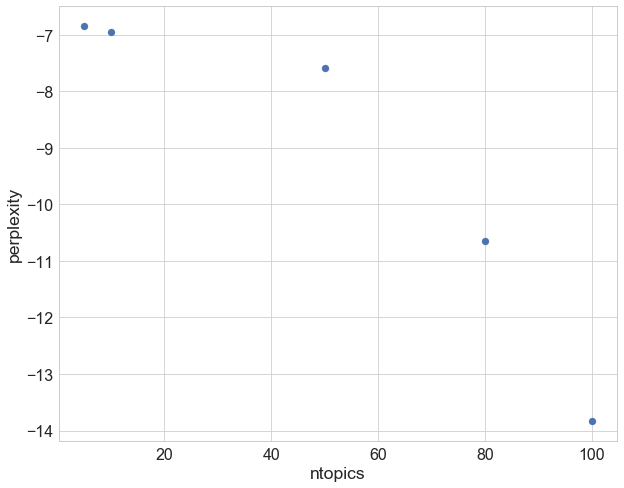

In [123]:
df_ntopic_perp=pd.DataFrame([(5,-6.85),(10,-6.95),(50,-7.58),(80,-10.65),(100,-13.83)],columns=['ntopics','perplexity'])
df_ntopic_perp.plot(kind='scatter',x='ntopics',y='perplexity',s=50);

### Visualize Topics with pyLDAvis
Pick the optimal model and visualize and interpret topics with pyLDAvis.

In [34]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda_gensim = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))
lda_display_gsm = pyLDAvis.gensim.prepare(lda_gensim, corpus, dictionary, sort_topics=False)

# Save the visualization in a html format
pyLDAvis.save_html(lda_display_gsm, 'gensimldan{0}.html'.format(ntopics))

# Interactive visualization
pyLDAvis.display(lda_display)
#takes 

![title](img/ldavis_gensimn5.png)
For an interactive visualization, click [here](https://)

In [35]:
ntopics=10


_=build_lda(rev_gens,ntopics=ntopics,passes=15)  #1.5hour

dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda_gensim = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))
lda_displayn10 = pyLDAvis.gensim.prepare(lda_gensim, corpus, dictionary, sort_topics=False)

# Save the visualization in a html format
pyLDAvis.save_html(lda_displayn10, 'gensimldan{0}.html'.format(ntopics))

# Interactive visualization
pyLDAvis.display(lda_displayn10)

Topics:
 (0, '0.094*"staff" + 0.085*"room" + 0.056*"location" + 0.054*"breakfast" + 0.046*"good" + 0.045*"friendly" + 0.040*"great" + 0.040*"clean" + 0.039*"helpful" + 0.031*"nice"')
Topics:
 (1, '0.094*"bar" + 0.059*"restaurant" + 0.045*"food" + 0.039*"service" + 0.028*"breakfast" + 0.026*"area" + 0.024*"drink" + 0.015*"eat" + 0.014*"serve" + 0.014*"dinner"')
Topics:
 (2, '0.039*"room" + 0.024*"check" + 0.021*"staff" + 0.017*"book" + 0.017*"get" + 0.015*"day" + 0.015*"ask" + 0.014*"time" + 0.013*"reception" + 0.013*"give"')
Topics:
 (3, '0.048*"station" + 0.042*"walk" + 0.040*"close" + 0.029*"location" + 0.029*"city" + 0.022*"minute" + 0.019*"good" + 0.019*"easy" + 0.019*"train" + 0.019*"center"')
Topics:
 (4, '0.056*"good" + 0.051*"room" + 0.047*"breakfast" + 0.038*"location" + 0.035*"price" + 0.025*"parking" + 0.023*"pool" + 0.017*"value" + 0.016*"money" + 0.016*"small"')
Topics:
 (5, '0.084*"room" + 0.033*"bed" + 0.022*"bathroom" + 0.018*"shower" + 0.015*"small" + 0.013*"location" 

![title](img/ldavis_gensimn10.png)
For an interactive visualization, click [here](https://)

### Test on Holdout data

In [39]:
#dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
#corpus = pickle.load(open('corpus.pkl', 'rb'))
lda_gensimn10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')
lda_gensimn5 = gensim.models.ldamodel.LdaModel.load('model5.gensim')




new_doc=df_txt['Rev_Lemmatized'][~mask].sample(1,random_state=100)
doc_tokenized=process_text(new_doc)
doc_bow=[dictionary.doc2bow(d) for d in doc_tokenized]
dtm=lda_gensimn10.get_document_topics(doc_bow)
print(new_doc.values)


print('For 10-topic model: ')
for t in dtm:
    print(t)

dtm=lda_gensimn5.get_document_topics(doc_bow)
print('For 5-topic model: ')
for t in dtm:
    print(t)


['make room reservation booking pay room separate make huge mess charge time confuse key room reservation name room location good']
For 10-topic model: 
[(2, 0.6268212400705695), (5, 0.3350756342904477)]
For 5-topic model: 
[(1, 0.5957963906576259), (2, 0.10343491947595156), (4, 0.28128399193992903)]


# Build Machine Learning Models for Prediction 
Since we focus on the review texts in this part, we build machine learning models using features generated from texts. Before that we need to create our target variable 'label'. Since a reviewer's score ranges from 0 to 10, for simplicity, we classify a hotel as 'poor' if the score is below 7.1 and 'good' if it's between 7.1 and 9.5 otherwise 'excellent'.

## Create a Target Column

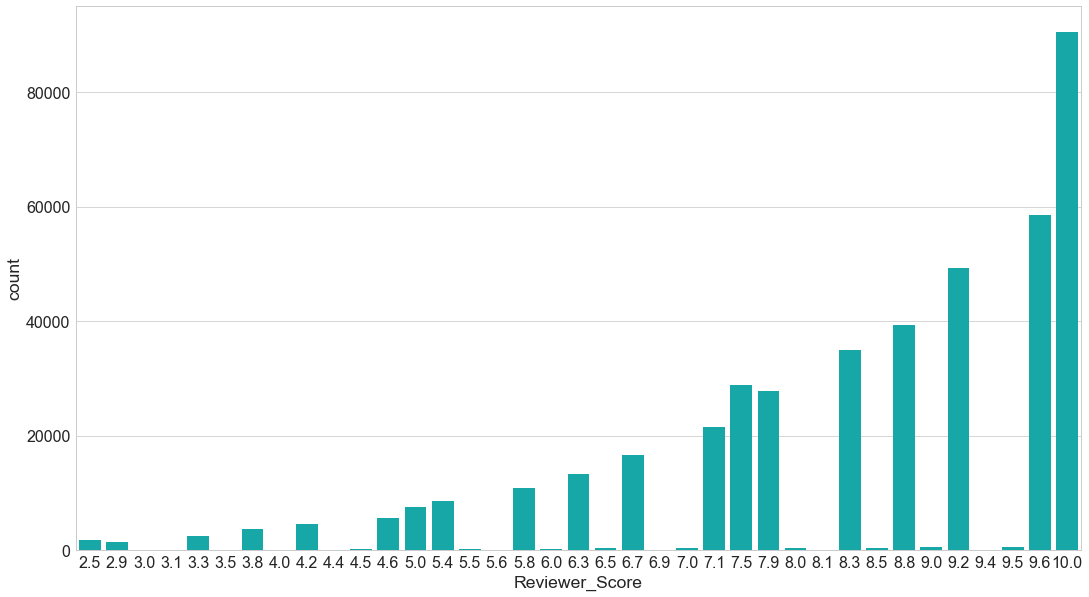

In [40]:
# Visualize the reviewer score
plt.figure(figsize=(18,10))
sns.countplot(df_txt.Reviewer_Score,color='c');

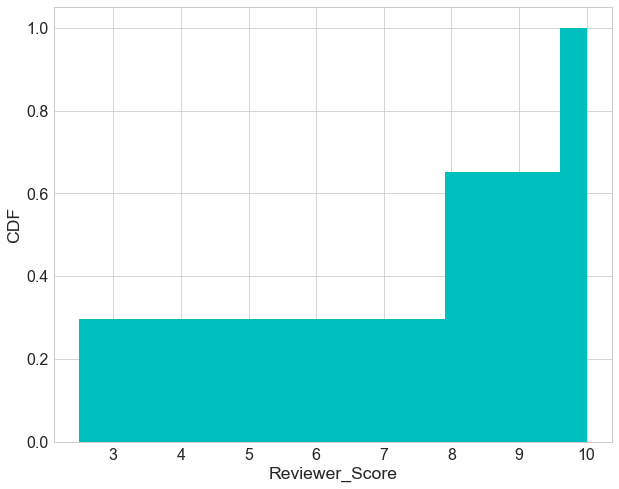

In [41]:
# Split Reviewe_Score into 3 buckets by quantiles
#pd.qcut(df_txt.Reviewer_Score,3).cat.categories
bins=[2.5, 7.9, 9.6, 10.0]
df_txt.Reviewer_Score.plot(kind='hist', cumulative=True,histtype='bar',normed=True,bins=bins,color='c')
plt.xlabel('Reviewer_Score')
plt.ylabel('CDF');

In [42]:
#Add 'label' by converting 'continuous' Reviewer_Score into 3 categories
df_txt['label']=pd.qcut(df_txt.Reviewer_Score,3,labels=['Poor','Good','Excellent'])

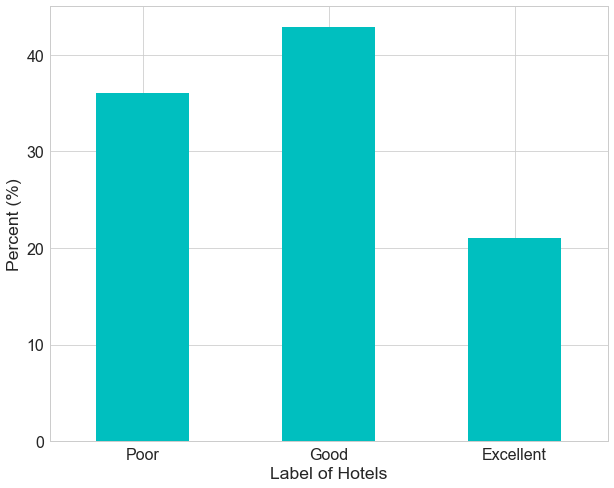

In [43]:
(df_txt.label.value_counts(normalize=True).sort_index()*100).plot(kind='bar',color='c',rot=0,figsize=(10,8));
plt.ylabel('Percent (%)')
plt.xlabel('Label of Hotels');

In [44]:
df_txt.drop('Reviewer_Score',axis=1).groupby('label').describe()

Hotel_City                       Neg_Rev_Lemmatized          \
               count unique     top   freq              count  unique   
label                                                                   
Poor          154949      6  London  84868             148202  142182   
Good          184068      6  London  89666             144192  122609   
Excellent      90447      6  London  44921              51094   31824   

                         Negative_Review                     \
               top  freq           count  unique top   freq   
label                                                         
Poor       nothing   498          154949  146047       6431   
Good       nothing  5770          184068  131420      38974   
Excellent  nothing  9312           90447   36354      38138   

          Pos_Rev_Lemmatized                           Positive_Review  \
                       count  unique         top  freq           count   
label                                                                    
Poor                  136610  101312    location  7260          154949   
Good                  179157  165756    location   843          184068   
Excellent              89422   87059  everything   223           90447   

                             Rev_Lemmatized          \
           unique top   freq          count  unique   
label                                                 
Poor       113815      18185         154949  154844   
Good       173286       4840         184068  183901   
Excellent   88636        987          90447   90335   

                                                                   \
                                                         top freq   
label                                                               
Poor                                     room small location    5   
Good                                  staff friendly helpful   13   
Excellent   room spacious nicely arrange separate busines...    8   

          Review_Month                    Reviewer_Nationality         \
                 count unique  top   freq                count unique   
label                                                                   
Poor            154949     12  Jul  15462               154949    206   
Good            184068     12  Aug  18022               184068    206   
Excellent        90447     12  Aug   9141                90447    179   

                                   Traveler_Type                        \
                        top   freq         count unique     top   freq   
label                                                                    
Poor        United Kingdom   71781        154949      6  Couple  70738   
Good        United Kingdom   88058        184068      6  Couple  93284   
Excellent   United Kingdom   48595         90447      6  Couple  48925   

          Trip_Type                               
              count unique           top    freq  
label                                             
Poor         149850      2  Leisure trip  118401  
Good         179392      2  Leisure trip  153483  
Excellent     88273      2  Leisure trip   78898

In [45]:
# Lenghth of characters in a full-review
df_txt['Len_LemRev_char']=df_txt['Rev_Lemmatized'].apply(len)


Correlation: -0.12


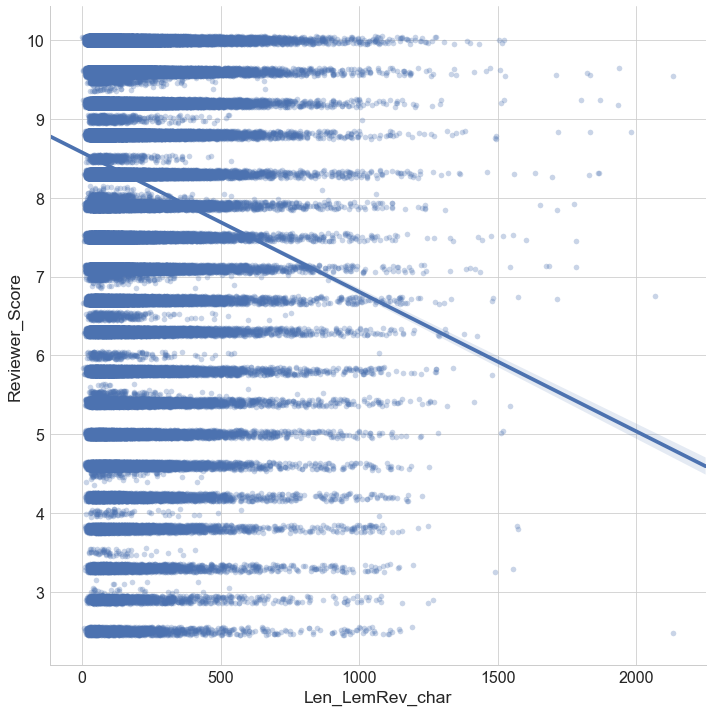

In [46]:
# How is the length of lemmatized clean reviews related with the reviewer score
sns.lmplot(y='Reviewer_Score',x='Len_LemRev_char',data=df_txt,y_jitter=0.05,size=10,scatter_kws={'alpha':0.3});
print('Correlation: %.2f'%(df_txt.Len_LemRev_char.corr(df_txt.Reviewer_Score)))

The above figure indicates that the longer the character length of a review the lower the score tends to be.

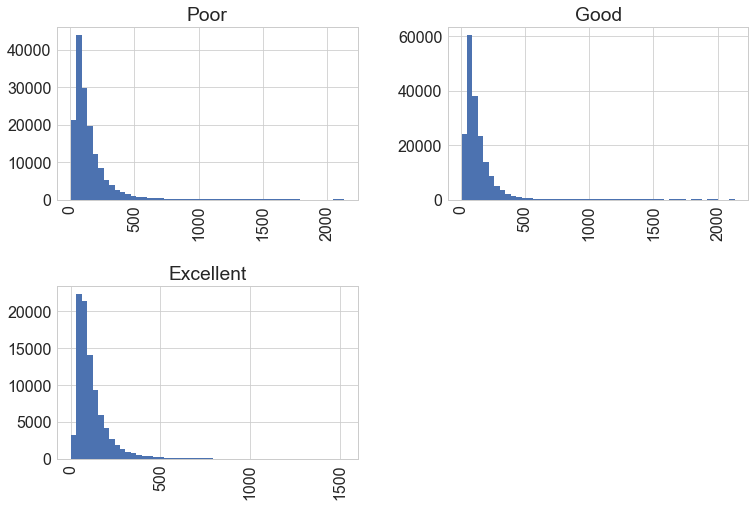

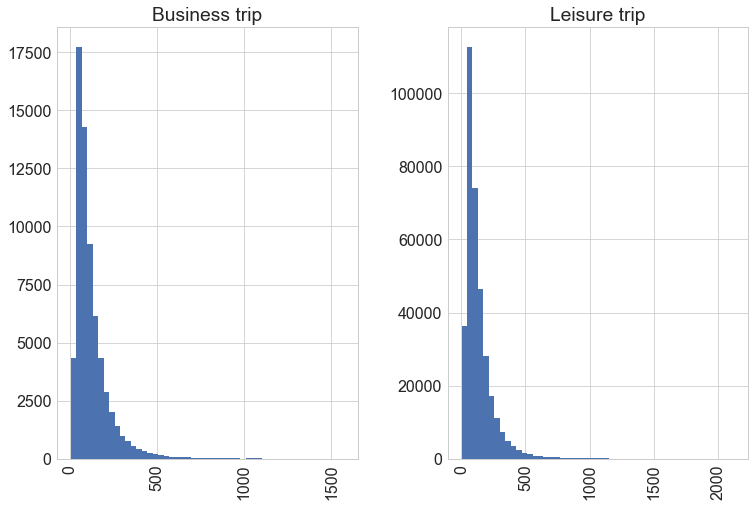

In [47]:
# Visualize the distribution of length of review strings by hotel label
df_txt.hist(column='Len_LemRev_char',by='label',bins=50,figsize=(12,8))
plt.xlabel('length of Characters in a Review');


# Visualize the distribution of length of review strings by traveler type
df_txt.hist(column='Len_LemRev_char',by='Trip_Type',bins=50,figsize=(12,8));



### t-test of the Character Length of Reviews
Is the average length of reviews significantly different for different trip categories (traveler types)? We will investigate this issue by performing the T-test for means of two independent samples of reviews. Null hypothesis is that 2 independent samples (i.e., character length of reviews for business trip and that for leisure trip) have identical average (expected) length of characters. This is a two-sided test for 2 samples of different sizes. 

In [48]:
np.round(df_txt.groupby('Trip_Type')['Len_LemRev_char'].size())#.mean())

Trip_Type
Business trip     66733
Leisure trip     350782
Name: Len_LemRev_char, dtype: int64

In [49]:
from scipy import stats

idx_leis=df_txt['Trip_Type']=='Leisure trip'
len_leis=df_txt[idx_leis]['Len_LemRev_char']
len_busi=df_txt[~idx_leis]['Len_LemRev_char']

t, p=stats.ttest_ind(len_leis, len_busi, equal_var = False)
#This test assumes that the populations have identical variances by default.
#equal_var=False: perform Welch’s t-test, which does not assume equal population variance 
print('t-statistic: %.2f' % (t),'\npvalue: %.2f' % (p))

t-statistic: 18.93 
pvalue: 0.00


Since the pvalue is nearly zero, we reject the null hypothesis and conclude that the average length of characters is different for reviews on leisure trip and business trip.

In [50]:
np.round(df_txt.groupby('label')['Len_LemRev_char'].size())#.mean())

label
Poor         154949
Good         184068
Excellent     90447
Name: Len_LemRev_char, dtype: int64

In [51]:
from scipy import stats

idx_poor=df_txt['label']=='Poor'
idx_good=df_txt['label']=='Good'
idx_exc=df_txt['label']=='Excellent'


len_poor=df_txt[idx_poor]['Len_LemRev_char']
len_good=df_txt[idx_good]['Len_LemRev_char']
len_exc=df_txt[idx_exc]['Len_LemRev_char']


t, p=stats.ttest_ind(len_poor, len_good, equal_var = False)
#This test assumes that the populations have identical variances by default.
#equal_var=False: perform Welch’s t-test, which does not assume equal population variance 
print('len_rev: poor v.s. good')
print('t-statistic: %.2f' % (t),'\npvalue: %.2f\n' % (p))

t, p=stats.ttest_ind(len_poor, len_exc, equal_var = False)
print('len_rev: poor v.s. exc')
print('t-statistic: %.2f' % (t),'\npvalue: %.2f\n' % (p))

t, p=stats.ttest_ind(len_good, len_exc, equal_var = False)
print('len_rev: good v.s. exc')
print('t-statistic: %.2f' % (t),'\npvalue: %.2f' % (p))

len_rev: poor v.s. good
t-statistic: 42.40 
pvalue: 0.00

len_rev: poor v.s. exc
t-statistic: 59.76 
pvalue: 0.00

len_rev: good v.s. exc
t-statistic: 25.21 
pvalue: 0.00


Since the pvalue is nearly zero for any two types of review categories, we reject the null hypothesis and conclude that the character length of reviews for different review categories are different.

## Build up a Pipeline

### Encoding the Categorical Target Feature

In [52]:
# LabelEncoding the review categories
df_txt_label=df_txt[['Reviewer_Score','Rev_Lemmatized','label']]
df_txt_label['label_cat']=df_txt_label.label.astype('category').cat.codes
#df_txt_label.isnull().sum()

In [53]:
lab_code=sorted(dict(zip(df_txt_label['label'],df_txt_label['label_cat'])).items(),key=lambda x: x[1])
lab_code

[('Poor', 0), ('Good', 1), ('Excellent', 2)]

In [ ]:
# # Save the full data with encoded target feature for machine learning prediction
# df_ml=df_txt.copy()
# df_ml['label_cat']=df_ml.label.astype('category').cat.codes
# df_ml.to_csv('data/htl_rev_lem_label_added.csv')

**Split data into training and test set**

In [54]:
X_train, X_test, y_train, y_test=train_test_split(df_txt_label['Rev_Lemmatized'],df_txt_label['label_cat'],test_size=0.3,random_state=100)
# If we set y as raw score,i.e., if we predict the raw score, the accuracy is  even lower
#X_train, X_test, y_train, y_test=train_test_split(df_txt_label['Rev_Lemmatized'],df_txt_label['Reviewer_Score'].astype('category').cat.codes,test_size=0.3,random_state=100)


y_train.shape, y_test.shape

((300624,), (128840,))

In [55]:
# Define a function to run pipeline
def run_pipeline(steps,X_train,y_train,X_test,y_test):
    pipe=Pipeline(steps)
    pipe.fit(X_train,y_train)
    
    y_pred=pipe.predict(X_test)
    accu_train=pipe.score(X_train,y_train)
    accu_test=pipe.score(X_test,y_test)
    class_rep=classification_report(y_test,y_pred)
    conf_mtrix=confusion_matrix(y_test, y_pred) #,labels=['Poor','Good','Excellent']

    # Save the model
    #pickle.dump(pipe, open('pipe_model', 'wb'))
   
    print('Accuracy of training set: %.2f' %accu_train)
    print('Accuracy of test set: %.2f' %accu_test)
    print("\nConfusion Matrix:\n",conf_mtrix )
    print ('\nClassificatio Report:\n',class_rep)


    return pipe,accu_train, accu_test, conf_mtrix, class_rep

    

## Use bag-of-word Features for Prediction 

**Build up the pipeline**

In [57]:
bow_steps=[('vectorise',CountVectorizer(min_df=10,stop_words='english',token_pattern='[a-zA-Z]{3,}')),
         ('clf',MultinomialNB())]

bow_pipe,bow_training_accuracy, bow_test_accuracy, bow_conf_mtrix, bow_class_report=run_pipeline(bow_steps,X_train,y_train,X_test,y_test)

Accuracy of training set: 0.62
Accuracy of test set: 0.61

Confusion Matrix:
 [[30356 14697  1195]
 [11021 33704 11025]
 [ 1976 10811 14055]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.70      0.66      0.68     46248
          1       0.57      0.60      0.59     55750
          2       0.53      0.52      0.53     26842

avg / total       0.61      0.61      0.61    128840



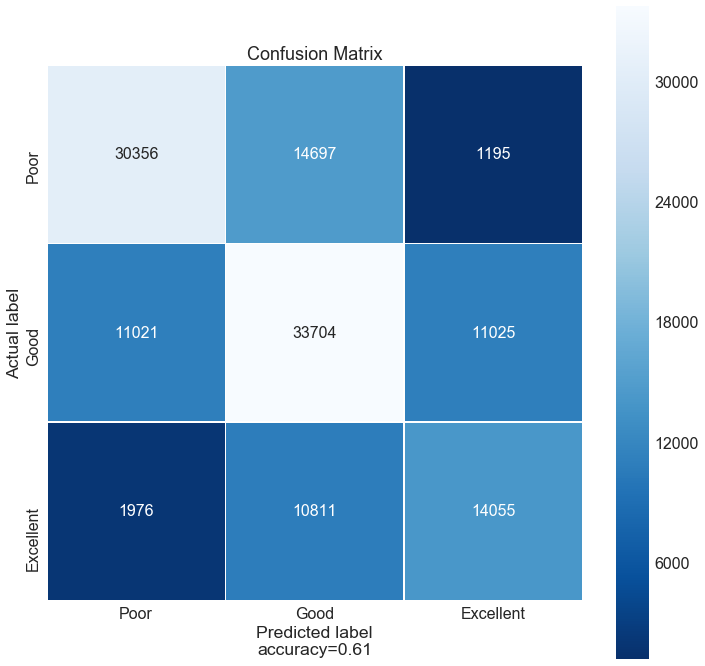

In [66]:
y_pred=bow_pipe.predict(X_test)


plt.figure(figsize=(12,12))
ax=sns.heatmap(bow_conf_mtrix, annot=True, fmt="d",linewidths=.5, square = True, cmap = 'Blues_r',annot_kws={'size':16});#fmt=".3f", 
plt.ylabel('Actual label');
#plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy_score(y_test,  y_pred), 1-accuracy_score(y_test,  y_pred)))
plt.xlabel('Predicted label\naccuracy={:0.2f}'.format(accuracy_score(y_test,  y_pred)))


plt.title('Confusion Matrix', size = 18)
ax.xaxis.set_ticklabels(['Poor', 'Good', 'Excellent'])
ax.yaxis.set_ticklabels(['Poor', 'Good', 'Excellent']);

In [65]:
# # Save model using pickle
pickle.dump(bow_pipe, open('save/bow_pipe_model.sav', 'wb'))

# load the model from disk
#bow_model=pickle.load(open('save/bow_pipe_model.sav', 'rb'))



pickle.dump(bow_training_accuracy, open('save/bow_training_accuracy.sav', 'wb'))
pickle.dump(bow_test_accuracy, open('save/bow_test_accuracy.sav', 'wb'))
pickle.dump(bow_conf_mtrix, open('save/bow_conf_mtrix.sav', 'wb'))
pickle.dump(bow_class_report, open('save/bow_class_report.sav', 'wb'))


### Grid Search Hyperparameters

In [67]:
bow_pipe.named_steps.keys()

dict_keys(['vectorise', 'clf'])

In [68]:
# Define a function for GridSearch
def my_grid_search(model,search_params,X_train,y_train,X_test,y_test,nfolds=5,scoring='accuracy'):
    gsmodel= GridSearchCV(model, param_grid=search_params,scoring=scoring,cv=nfolds)
    gsmodel=gsmodel.fit(X_train,y_train)
    
    # Save the best model
    # best_model=gsmodel.best_estimator_
    # pickle.dump(best_model,open('bestmodel','wb'))
            
    y_pred=gsmodel.predict(X_test)
    print('Best paras:\n')
    pprint(gsmodel.best_params_)
    print('\nBest score: %.2f' % gsmodel.best_score_)
    print('\nClassification report: \n',classification_report(y_test,y_pred))
    
    return gsmodel,gsmodel.best_params_,gsmodel.best_score_,classification_report(y_test,y_pred)


#steps=[('vectorise',CountVectorizer(stop_words='english',token_pattern='[a-zA-Z]{3,}')),
#         ('clf',MultinomialNB())]
#res_rp=run_pipeline(steps,X_train,y_train,X_test,y_test)   



In [ ]:
nfolds=5
search_params = dict(vectorise__binary=[True,False],
                  vectorise__min_df=[1,10],
                  vectorise__ngram_range=[(1,1),(1,2)],
                  clf__alpha=[0.1,1,10]
                 )

bowGS, _,_, bowGS_class_report=my_grid_search(bow_pipe,search_params,X_train,y_train,X_test,y_test,nfolds,scoring='accuracy')

bow_GridSearch_training_accuracy=bowGS.score(X_train,y_train)
bow_GridSearch_test_accuracy=bowGS.score(X_test,y_test)
bow_GridSearch_conf_mtrix=confusion_matrix(y_test,bowGS.predict(X_test))
bow_GridSearch_class_report=bowGS_class_report


# # Save model using pickle
pickle.dump(bowGS, open('save/bowGridSearch.sav', 'wb'))
# some time later...
# load the model from disk
#bow_GS_model=pickle.load(open('save/bowGridSearch.sav', 'rb'))



pickle.dump(bow_GridSearch_training_accuracy, open('save/bow_GridSearch_training_accuracy.sav', 'wb'))
pickle.dump(bow_GridSearch_test_accuracy, open('save/bow_GridSearch_test_accuracy.sav', 'wb'))
pickle.dump(bow_GridSearch_conf_mtrix, open('save/bow_GridSearch_conf_mtrix.sav', 'wb'))
pickle.dump(bow_GridSearch_class_report, open('save/bow_GridSearch_class_reportt.sav', 'wb'))



In [69]:
# Load model using pickle
bowGS=pickle.load(open('save/bowGridSearch.sav', 'rb'))
bow_GridSearch_training_accuracy=pickle.load(open('save/bow_GridSearch_training_accuracy.sav', 'rb'))
bow_GridSearch_test_accuracy=pickle.load(open('save/bow_GridSearch_test_accuracy.sav', 'rb'))
bow_GridSearch_conf_mtrix=pickle.load(open('save/bow_GridSearch_conf_mtrix.sav', 'rb'))
bow_GridSearch_class_report=pickle.load(open('save/bow_GridSearch_class_reportt.sav', 'rb'))

In [70]:
print('Best paras:\n')
pprint(bowGS.best_params_)
print('\nBest score: %.2f' % bowGS.best_score_)
print('\nClassification report: \n',bow_GridSearch_class_report)

Best paras:

{'clf__alpha': 10,
 'vectorise__binary': True,
 'vectorise__min_df': 10,
 'vectorise__ngram_range': (1, 2)}

Best score: 0.62

Classification report: 
              precision    recall  f1-score   support

          0       0.71      0.68      0.70     46248
          1       0.57      0.70      0.63     55750
          2       0.60      0.38      0.46     26842

avg / total       0.63      0.62      0.62    128840



### Strongly Predictive Features 
We build a dataset where each row contains just one word (identity matrix) and then uses the trained classifier to classify the one-word review. The probability for each row represents the probability that the review will be classified as 'poor'. We can see which words have the highest probability in ('poor') and which words have the lowest probability (low probability in being 'poor', hence high probability in being 'good' or 'excellent).

In [71]:
#Initialize the CountVectorizer
vectorizer=CountVectorizer(analyzer='word',       
                             min_df=10,
                             ngram_range=(1, 2),
                             stop_words='english',             
                             lowercase=True,                  
                             token_pattern='[a-zA-Z]{3,}',  
                            binary=True,
                       )
# Build the vocabulary by 'fit'
vectorizer.fit(df_txt_label['Rev_Lemmatized'])


#Make X and y
def make_xy(df_txt_label, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df_txt_label.Rev_Lemmatized)
    X = X.tocsc()  
    y = df_txt_label.label_cat.values
    return X, y
X, y = make_xy(df_txt_label,vectorizer)


# Set the train and test masks
itrain, _ = train_test_split(range(df_txt_label.shape[0]), test_size=0.3,random_state=100)
mask = np.zeros(df_txt_label.shape[0], dtype=np.bool)
mask[itrain] = True

xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

#Train the Naive Bayes model
clf = MultinomialNB(alpha=10).fit(xtrain, ytrain)
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
# 'poor'
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)[::-1]#reverse the order such that decending order

good_words =words[ind[:10]]   
bad_words =words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(Poor | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(np.exp(p)))
    
print("Bad words\t     P(Poor | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(np.exp(p)))



Good words	     P(Poor | word)
          staff rude 0.90
          room dirty 0.89
              filthy 0.89
           unhelpful 0.87
          dirty room 0.87
        carpet dirty 0.86
    staff unfriendly 0.86
     staff unhelpful 0.85
               dirty 0.85
   uncomfortable bed 0.85
Bad words	     P(Poor | word)
           feel home 0.06
       amazing staff 0.06
         stay highly 0.06
  absolutely amazing 0.06
   definitely return 0.05
     definitely come 0.05
     absolutely love 0.05
     definitely stay 0.05
           love stay 0.04
    highly recommend 0.03


**Compare different classifiers**<br>
It is quite time-consuming, we will perform the calculations in cluster and import results to notebook.

In [ ]:

clfs=[MultinomialNB(),LogisticRegression(),SGDClassifier(loss="log")]
model_clf=['MultinomialNB','LogisticRegression','SGDClassifier']
search_params=[dict(vectorise__binary=[True,False],
                    #vectorise__min_df=[1,5,10],
                    vectorise__ngram_range=[(1,1),(1,2)],
                    clf__alpha=[0.01,0.1,1,10]
                 ),
              dict(vectorise__binary=[True,False],
                    #vectorise__min_df=[1,5,10],
                    vectorise__ngram_range=[(1,1),(1,2)],
                   clf__C=[0.01,0.1,1,10]
                 ),
              dict(vectorise__binary=[True,False],
                   # vectorise__min_df=[1,5,10],
                    vectorise__ngram_range=[(1,1),(1,2)],
                 )]


nfolds=5
for i in range(len(clfs)):
    steps=[('vectorise',CountVectorizer(stop_words='english')),
         ('clf',clfs[i])]
    pipe=Pipeline(steps)
    
    print('Model: ', model_clf[i])    
    grid_search =my_grid_search(pipe,search_params[i],X_train,y_train,X_test,y_test,nfolds,scoring='accuracy')

Below are the results for the grid search.

Model:  MultinomialNB
{'clf__alpha': 1, 'vectorise__binary': False, 'vectorise__ngram_range': (1, 2)}

Best score: 0.62

Classification report: 
              precision    recall  f1-score   support

          0       0.72      0.66      0.69     46248
          1       0.56      0.75      0.64     55750
          2       0.65      0.29      0.40     26842

avg / total       0.64      0.62      0.61    128840

Model:  LogisticRegression
{'clf__C': 0.01, 'vectorise__binary': False, 'vectorise__ngram_range': (1, 2)}

Best score: 0.63

Classification report: 
              precision    recall  f1-score   support

          0       0.71      0.72      0.71     46248
          1       0.58      0.71      0.64     55750
          2       0.64      0.32      0.43     26842

avg / total       0.64      0.63      0.62    128840

Model:  SGDClassifier
{'vectorise__binary': True, 'vectorise__ngram_range': (1, 2)}

Best score: 0.63

Classification report: 
              precision    recall  f1-score   support

          0       0.73      0.70      0.71     46248
          1       0.57      0.73      0.64     55750
          2       0.64      0.32      0.42     26842

avg / total       0.64      0.63      0.62    128840

## Use Tfidf-weighted Features for Prediction 
We already have a learned CountVectorizer, we will use it with a TfidfTransformer to generate the Tfidf-weighted features for prediction.

In [72]:
steps=[('vectorise', CountVectorizer(analyzer='word',       
                             min_df=10,
                             ngram_range=(1, 2),
                             stop_words='english',             
                             lowercase=True,                  
                             token_pattern='[a-zA-Z]{3,}',  
                            #binary=False,
                       )),
       ('transform',TfidfTransformer()),
       ('clf',MultinomialNB())]
res_tfidf_NB_model=run_pipeline(steps,X_train,y_train,X_test,y_test)      

# # Save model using pickle
pickle.dump(res_tfidf_NB_model, open('save/tfidf_NB_model.sav', 'wb'))
# some time later...
# load the model from disk
#res_tfidf_NB_model=pickle.load(open('save/tfidf_NB_model.sav', 'rb'))


tfidf_NB_training_accuracy=res_tfidf_NB_model[1]
tfidf_NB_test_accuracy=res_tfidf_NB_model[2]
tfidf_NB_conf_mtrix=res_tfidf_NB_model[3]
tfidf_NB_class_report=res_tfidf_NB_model[4]

pickle.dump(tfidf_NB_training_accuracy, open('save/tfidf_NB_training_accuracy.sav', 'wb'))
pickle.dump(tfidf_NB_test_accuracy, open('save/tfidf_NB_test_accuracy.sav', 'wb'))
pickle.dump(tfidf_NB_conf_mtrix, open('save/tfidf_NB_conf_mtrix.sav', 'wb'))
pickle.dump(tfidf_NB_class_report, open('save/tfidf_NB_class_report.sav', 'wb'))




Accuracy of training set: 0.66
Accuracy of test set: 0.62

Confusion Matrix:
 [[31528 14384   336]
 [10837 40223  4690]
 [ 1821 16322  8699]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.71      0.68      0.70     46248
          1       0.57      0.72      0.64     55750
          2       0.63      0.32      0.43     26842

avg / total       0.63      0.62      0.61    128840



In [75]:
steps=[('vectorise', CountVectorizer(analyzer='word',       
                             min_df=10,
                             ngram_range=(1, 2),
                             stop_words='english',             
                             lowercase=True,                  
                             token_pattern='[a-zA-Z]{3,}',  
                            #binary=False,
                       )),
       ('transform',TfidfTransformer()),
       ('clf',LogisticRegression())]
res_tfidf_Lg_model=run_pipeline(steps,X_train,y_train,X_test,y_test)      

# # Save model using pickle
pickle.dump(res_tfidf_Lg_model, open('save/tfidf_Lg_model.sav', 'wb'))
# some time later...
# load the model from disk
#res_tfidf_Lg_model=pickle.load(open('save/tfidf_Lg_model.sav', 'rb'))


tfidf_Lg_training_accuracy=res_tfidf_Lg_model[1]
tfidf_Lg_test_accuracy=res_tfidf_Lg_model[2]
tfidf_Lg_conf_mtrix=res_tfidf_Lg_model[3]
tfidf_Lg_class_report=res_tfidf_Lg_model[4]

pickle.dump(tfidf_Lg_training_accuracy, open('save/tfidf_Lg_training_accuracy.sav', 'wb'))
pickle.dump(tfidf_Lg_test_accuracy, open('save/tfidf_Lg_test_accuracy.sav', 'wb'))
pickle.dump(tfidf_Lg_conf_mtrix, open('save/tfidf_Lg_conf_mtrix.sav', 'wb'))
pickle.dump(tfidf_Lg_class_report, open('save/tfidf_Lg_class_report.sav', 'wb'))

Accuracy of training set: 0.70
Accuracy of test set: 0.63

Confusion Matrix:
 [[33665 12035   548]
 [12295 37170  6285]
 [ 1910 14498 10434]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.70      0.73      0.72     46248
          1       0.58      0.67      0.62     55750
          2       0.60      0.39      0.47     26842

avg / total       0.63      0.63      0.62    128840



### Feed Less TfidfVectorized Features to Classifier 
We select only some (rather than all) features by implementing the most common feature selection technique for text mining, i.e., the chi-squared  ($\chi2$) method to see if the accuracy gets improved on test data set.



In [79]:
tfidf_vec = TfidfVectorizer(min_df=10,
                            ngram_range=(1, 2),
                            stop_words='english',
                            token_pattern='[a-zA-Z]{3,}',
                           )

X, y = make_xy(df_txt_label,tfidf_vec)
#X_new = SelectKBest(chi2, k=10).fit_transform(X, y)
X_new = SelectKBest(chi2, k=5000).fit_transform(X, y)


itrain, _ = train_test_split(range(df_txt_label.shape[0]), test_size=0.3,random_state=100)
mask = np.zeros(df_txt_label.shape[0], dtype=np.bool)
mask[itrain] = True



Xtrain=X_new[mask]
ytrain=y[mask]
Xtest=X_new[~mask]
ytest=y[~mask]


In [81]:
steps=[#('vectorise',TfidfVectorizer(stop_words='english',token_pattern='[a-zA-Z]{3,}')),
       ('clf',MultinomialNB())]

res_tfidf_NB_model2=run_pipeline(steps,Xtrain,ytrain,Xtest,ytest)            


# # Save model using pickle
pickle.dump(res_tfidf_NB_model2, open('save/tfidf_chi_NB_model.sav', 'wb'))
# some time later...
# load the model from disk
#res_tfidf_NB_model2=pickle.load(open('save/tfidf_chi_NB_model.sav', 'rb'))


tfidf_chi_training_accuracy=res_tfidf_NB_model2[1]
tfidf_chi_test_accuracy=res_tfidf_NB_model2[2]
tfidf_chi_conf_mtrix=res_tfidf_NB_model2[3]
tfidf_chi_class_report=res_tfidf_NB_model2[4]


pickle.dump(tfidf_chi_training_accuracy, open('save/tfidf_chi_training_accuracy.sav', 'wb'))
pickle.dump(tfidf_chi_test_accuracy, open('save/tfidf_chi_test_accuracy.sav', 'wb'))
pickle.dump(tfidf_chi_conf_mtrix, open('save/tfidf_chi_conf_mtrix.sav', 'wb'))
pickle.dump(tfidf_chi_class_report, open('save/tfidf_chi_class_report.sav', 'wb'))






Accuracy of training set: 0.62
Accuracy of test set: 0.62

Confusion Matrix:
 [[30375 15714   159]
 [ 9648 43050  3052]
 [ 1550 18456  6836]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.73      0.66      0.69     46248
          1       0.56      0.77      0.65     55750
          2       0.68      0.25      0.37     26842

avg / total       0.65      0.62      0.61    128840



In [ ]:
# search_params=dict(#vectorise__binary=[True,False],
#                   #vectorise__min_df=[1,5,10],
#                   #vectorise__ngram_range=[(1,1),(1,2)],
#                   clf__alpha=[0.001,0.005,0.01,0.05,0.1]
#                  )
# #tfidf_NB_model_gs_lessfeature=my_grid_search(tfidf_NB_model2[0],search_params,Xtrain,ytrain,Xtest,ytest,nfolds=5,scoring='accuracy')

**Ngram WordCloud**

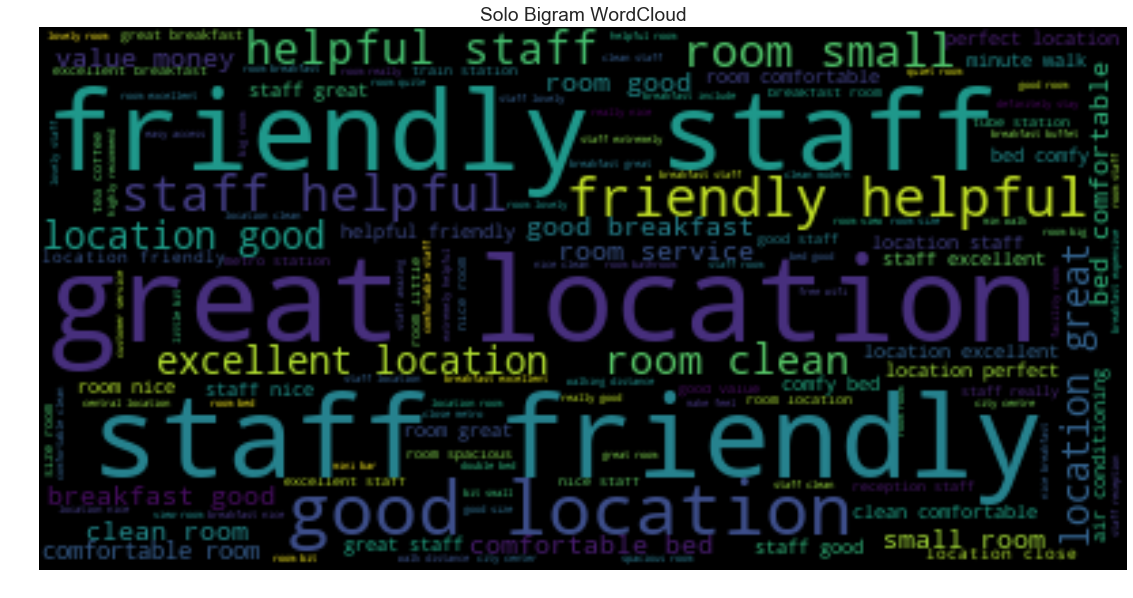

In [82]:
# Ngram
def ngram(n,txt):
    tfidf_vec = TfidfVectorizer(min_df=10, ngram_range=(1, n),stop_words='english',lowercase=True,token_pattern='[a-zA-Z]{3,}',max_features = 5000)
    tfidf_vec.fit(txt)
    tfidf_m=tfidf_vec.transform(txt)
    words_ngram=[w for w in tfidf_vec.get_feature_names() if len(w.split(' '))>n-1]
    idx_ngram=[tfidf_vec.vocabulary_[w] for w in words_ngram]
    dn=dict(zip(words_ngram, np.ravel(tfidf_m.sum(axis=0))[idx_ngram]))
    
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=dn)
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off");
# Unigram wordcloud
ngram(2,df_txt_label['Rev_Lemmatized'])
plt.title('Solo Bigram WordCloud');

## Use sklearn LDA Document Topics for Prediction

**Build up the pipeline**

In [83]:
#X_train, X_test, y_train, y_test=train_test_split(df_txt_label['Rev_Lemmatized'],df_txt_label['label_cat'],test_size=0.3,random_state=100)

steps=[('vectorise',CountVectorizer(analyzer='word',       
                             min_df=10,                       
                             stop_words='english',             
                             lowercase=True,                  
                             token_pattern='[a-zA-Z]{3,}',    # num chars > 3 
   )),
       ('LDA', LDA(n_components=5, random_state=100)),
       ('clf',MultinomialNB())]

res_ldan5=run_pipeline(steps,X_train,y_train,X_test,y_test)
# # Save model using pickle
pickle.dump(res_ldan5, open('save/res_ldan5.sav', 'wb'))

/Users/phyhouhou/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Accuracy of training set: 0.53
Accuracy of test set: 0.53

Confusion Matrix:
 [[20962 25286     0]
 [ 7970 47780     0]
 [ 1757 25085     0]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.68      0.45      0.54     46248
          1       0.49      0.86      0.62     55750
          2       0.00      0.00      0.00     26842

avg / total       0.46      0.53      0.46    128840



In [85]:
# load the model from disk
#res_lda=pickle.load(open('save/res_lda.sav', 'rb'))

lda_training_accuracyn5=res_ldan5[1]
lda_test_accuracyn5=res_ldan5[2]
lda_conf_mtrixn5=res_ldan5[3]
lda_class_reportn5=res_ldan5[4]


pickle.dump(lda_training_accuracyn5, open('save/lda_training_accuracyn5.sav', 'wb'))
pickle.dump(lda_test_accuracyn5, open('save/lda_test_accuracyn5.sav', 'wb'))
pickle.dump(lda_conf_mtrixn5, open('save/lda_conf_mtrixn5.sav', 'wb'))
pickle.dump(lda_class_reportn5, open('save/lda_class_reportn5.sav', 'wb'))

**Grid Search Hyperparameters**<br>
This step takes time and computing resources. 

In [ ]:
# steps=[('vectorise',CountVectorizer()),
#        #('transform',TfidfTransformer()),
#        ('LDA', LDA(n_components=5, random_state=100)),
#        ('clf',MultinomialNB())]

# model=run_pipeline(steps,X_train,y_train,X_test,y_test)
# print(model[0].named_steps.keys())

# search_params = dict(#vectorise__stop_words=[None,'english'],
#                   vectorise__binary=[True,False],
#                   vectorise__min_df=[1,5,10],
#                   vectorise__ngram_range=[(1,1),(1,2)],
#                   clf__alpha=[0.01,0.1,1,10]
#                  )

# res_GridSearch_lda=my_grid_search(model,search_params,X_train,y_train,X_test,y_test,nfolds=5,scoring='accuracy')

## Use Gensim LDA Document Topics for Prediction

In [86]:
# Define functions to extract topic features from gensim lda that can be used for prediction
def extract_listoftuple(ls,nth):
    """extract the nth elements of each tuple in a list of tuples"""
    return [i[nth] for i in ls]


def gensim_lda_feature(doc,dictionary,corpus,num_topics,ldamodel):
    """extract document-topic matrix from gensim lda and convert it into a form ready to be used for prediction """
    
    # Create document-topic-matrix for new documents
    doc_tokenized=process_text(doc)
    doc_bow=[dictionary.doc2bow(d) for d in doc_tokenized]
    dtm=ldamodel.get_document_topics(doc_bow)

        # Convert dtm to numpy array
    dtm_csr = gensim.matutils.corpus2csc(dtm)
    dtm_numpy = dtm_csr.T.toarray()

    return dtm_numpy
    

# a FunctionTransformer turns a python function into an object that a scikit-learn pipeline can understand
gensim_lda_extractFeature=FunctionTransformer(lambda x: gensim_lda_feature(x,dictionary,corpus,ntopics,lda),validate=False)

In [87]:
X_rev=df_txt_label['Rev_Lemmatized']
y=df_txt_label['label_cat']


# Split data into training and test set
itrain, _ = train_test_split(range(df_txt_label.shape[0]), test_size=0.3,random_state=100)
mask = np.zeros(df_txt_label.shape[0], dtype=np.bool)
mask[itrain] = True

X_train=X_rev[mask]
y_train=y[mask]

X_test=X_rev[~mask]
y_test=y[~mask]


ntopics=5
#build_lda(X_train,ntopics,passes=15);
    
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
ldan5 = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))
#gensim_lda_feature(X_train,dictionary,corpus,ntopics,ldan5)

In [88]:
# a FunctionTransformer turns a python function into an object that a scikit-learn pipeline can understand
gensim_lda_extractFeature=FunctionTransformer(lambda x: gensim_lda_feature(
    x,dictionary,corpus,ntopics,ldan5),validate=False)
steps=[('gensimLDA',gensim_lda_extractFeature),
       ('clf',MultinomialNB())]
res_lda_gsm_n5=run_pipeline(steps,X_train,y_train,X_test,y_test)
#14:36-14:50

Accuracy of training set: 0.53
Accuracy of test set: 0.53

Confusion Matrix:
 [[21223 25025     0]
 [ 8387 47363     0]
 [ 1602 25240     0]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.68      0.46      0.55     46248
          1       0.49      0.85      0.62     55750
          2       0.00      0.00      0.00     26842

avg / total       0.45      0.53      0.46    128840



In [89]:
lda_gsm_n5_training_accuracy=res_lda_gsm_n5[1]
lda_gsm_n5_test_accuracy=res_lda_gsm_n5[2]
lda_gsm_n5_conf_mtrix=res_lda_gsm_n5[3]
lda_gsm_n5_class_report=res_lda_gsm_n5[4]

# Save model using pickle
#pickle.dump(res_lda_gsm_n5, open('save/mlres_lda_gsm_n5.sav', 'wb'))

pickle.dump(lda_gsm_n5_training_accuracy, open('save/lda_gsm_n5_training_accuracy.sav', 'wb'))
pickle.dump(lda_gsm_n5_test_accuracy, open('save/lda_gsm_n5_test_accuracy.sav', 'wb'))
pickle.dump(lda_gsm_n5_conf_mtrix, open('save/lda_gsm_n5_conf_mtrix.sav', 'wb'))
pickle.dump(lda_gsm_n5_class_report, open('save/lda_gsm_n5_class_report.sav', 'wb'))


 # # Grid Search optimal parameters. Time-consuming    
# search_params = dict(clf__alpha=[0.01,0.1,1,10])
# res_Grid_Gensimlda=my_grid_search(model_gensiLDA,search_params,X_train,y_train,X_test,y_test,nfolds=5,scoring='accuracy');

In [90]:
ntopics=10
ldan10 = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))
#gensim_lda_feature(X_train,dictionary,corpus,ntopics,ldan10)


# a FunctionTransformer turns a python function into an object that a scikit-learn pipeline can understand
gensim_lda_extractFeature=FunctionTransformer(lambda x: gensim_lda_feature(
    x,dictionary,corpus,ntopics,ldan10),validate=False)
steps=[('gensimLDA',gensim_lda_extractFeature),
       ('clf',MultinomialNB())]
res_lda_gsm_n10=run_pipeline(steps,X_train,y_train,X_test,y_test)
#14:51-14:

Accuracy of training set: 0.53
Accuracy of test set: 0.54

Confusion Matrix:
 [[21743 24505     0]
 [ 8590 47146    14]
 [ 1797 24982    63]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.68      0.47      0.55     46248
          1       0.49      0.85      0.62     55750
          2       0.82      0.00      0.00     26842

avg / total       0.62      0.54      0.47    128840



In [91]:
lda_gsm_n10_training_accuracy=res_lda_gsm_n10[1]
lda_gsm_n10_test_accuracy=res_lda_gsm_n10[2]
lda_gsm_n10_conf_mtrix=res_lda_gsm_n10[3]
lda_gsm_n10_class_report=res_lda_gsm_n10[4]


pickle.dump(lda_gsm_n10_training_accuracy, open('save/lda_gsm_n10_training_accuracy.sav', 'wb'))
pickle.dump(lda_gsm_n10_test_accuracy, open('save/lda_gsm_n10_test_accuracy.sav', 'wb'))
pickle.dump(lda_gsm_n10_conf_mtrix, open('save/lda_gsm_n10_conf_mtrix.sav', 'wb'))
pickle.dump(lda_gsm_n10_class_report, open('save/lda_gsm_n10_class_report.sav', 'wb'))

##  Compare Model Performance

In [92]:
bow_training_accuracy=pickle.load(open('save/bow_training_accuracy.sav', 'rb'))
bow_test_accuracy=pickle.load(open('save/bow_test_accuracy.sav', 'rb'))
bow_conf_mtrix = pickle.load(open('save/bow_conf_mtrix.sav', 'rb'))
bow_class_report = pickle.load(open('save/bow_class_report.sav', 'rb'))


bow_GridSearch_training_accuracy=pickle.load(open('save/bow_GridSearch_training_accuracy.sav', 'rb'))
bow_GridSearch_test_accuracy=pickle.load(open('save/bow_GridSearch_test_accuracy.sav', 'rb'))
bow_GridSearch_conf_mtrix=pickle.load(open('save/bow_GridSearch_conf_mtrix.sav', 'rb'))
bow_GridSearch_class_report=pickle.load(open('save/bow_GridSearch_class_reportt.sav', 'rb'))


bow_NB_test_accuracy=0.62
bow_NB_class_report='             precision    recall  f1-score   support\n\n          0       0.72      0.66      0.69      46248\n          1       0.56      0.75      0.64      55750\n          2       0.65      0.29      0.40      26842\n\navg / total       0.64      0.62      0.61      128840\n'

bow_LR_test_accuracy=0.63
bow_LR_class_report='             precision    recall  f1-score   support\n\n          0       0.71      0.72      0.71      46248\n          1       0.58      0.71      0.64      55750\n          2       0.64      0.32      0.43      26842\n\navg / total       0.64      0.63      0.62      128840\n'

bow_SGD_test_accuracy=0.63
bow_SGD_class_report='             precision    recall  f1-score   support\n\n          0       0.73      0.70      0.71      46248\n          1       0.57      0.73      0.64      55750\n          2       0.64      0.32      0.42      26842\n\navg / total       0.64      0.63      0.62      128840\n'

tfidf_NB_training_accuracy=pickle.load(open('save/tfidf_NB_training_accuracy.sav', 'rb'))
tfidf_NB_test_accuracy=pickle.load(open('save/tfidf_NB_test_accuracy.sav', 'rb'))
tfidf_NB_conf_mtrix=pickle.load(open('save/tfidf_NB_conf_mtrix.sav', 'rb'))
tfidf_NB_class_report=pickle.load(open('save/tfidf_NB_class_report.sav', 'rb'))

tfidf_LR_training_accuracy=pickle.load(open('save/tfidf_Lg_training_accuracy.sav', 'rb'))
tfidf_LR_test_accuracy=pickle.load(open('save/tfidf_Lg_test_accuracy.sav', 'rb'))
tfidf_LR_conf_mtrix=pickle.load(open('save/tfidf_Lg_conf_mtrix.sav', 'rb'))
tfidf_LR_class_report=pickle.load(open('save/tfidf_Lg_class_report.sav', 'rb'))

tfidf_chi_training_accuracy=pickle.load(open('save/tfidf_chi_training_accuracy.sav', 'rb'))
tfidf_chi_test_accuracy=pickle.load(open('save/tfidf_chi_test_accuracy.sav', 'rb'))
tfidf_chi_conf_mtrix=pickle.load(open('save/tfidf_chi_conf_mtrix.sav', 'rb'))
tfidf_chi_class_report=pickle.load(open('save/tfidf_chi_class_report.sav', 'rb'))


lda_n5_training_accuracy=pickle.load(open('save/lda_training_accuracyn5.sav', 'rb'))
lda_n5_test_accuracy=pickle.load(open('save/lda_test_accuracyn5.sav', 'rb'))
lda_n5_conf_mtrix=pickle.load(open('save/lda_conf_mtrixn5.sav', 'rb'))
lda_n5_class_report=pickle.load(open('save/lda_class_reportn5.sav', 'rb'))

lda_gsm_n5_training_accuracy=pickle.load(open('save/lda_gsm_n5_training_accuracy.sav', 'rb'))
lda_gsm_n5_test_accuracy=pickle.load(open('save/lda_gsm_n5_test_accuracy.sav', 'rb'))
lda_gsm_n5_conf_mtrix=pickle.load(open('save/lda_gsm_n5_conf_mtrix.sav', 'rb'))
lda_gsm_n5_class_report=pickle.load(open('save/lda_gsm_n5_class_report.sav', 'rb'))


lda_gsm_n10_training_accuracy=pickle.load(open('save/lda_gsm_n10_training_accuracy.sav', 'rb'))
lda_gsm_n10_test_accuracy=pickle.load(open('save/lda_gsm_n10_test_accuracy.sav', 'rb'))
lda_gsm_n10_conf_mtrix=pickle.load(open('save/lda_gsm_n10_conf_mtrix.sav', 'rb'))
lda_gsm_n10_class_report=pickle.load(open('save/lda_gsm_n10_class_report.sav', 'rb'))

In [93]:
# Accuracy score of the training and test set for each model
model_accuracy={
                'bow':[ bow_test_accuracy],
                'bow_GridSearch': [bow_GridSearch_test_accuracy],
                'bow_Classifier_NB': [bow_NB_test_accuracy],
                'bow_Classifier_LR': [bow_LR_test_accuracy],
                'bow_Classifier_SGD': [bow_SGD_test_accuracy],
                'tfidf_NB':[tfidf_NB_test_accuracy],
                'tfidf_LR':[tfidf_LR_test_accuracy],
                'tfidf_chi':[tfidf_chi_test_accuracy],
                'lda':[lda_n5_test_accuracy],
                'lda_gensim_n5':[lda_gsm_n5_test_accuracy],
                'lda_gensim_n10':[lda_gsm_n10_test_accuracy], 
}
model_performance=pd.DataFrame.from_dict(model_accuracy,orient='index')
model_performance.columns=['test_accuracy']
np.round(model_performance,2)#.T

,test_accuracy
bow,0.61
bow_GridSearch,0.62
bow_Classifier_NB,0.62
bow_Classifier_LR,0.63
bow_Classifier_SGD,0.63
tfidf_NB,0.62
tfidf_LR,0.63
tfidf_chi,0.62
lda,0.53
lda_gensim_n5,0.53


In [94]:
# Print classification report
print('bow: \n')
print(bow_class_report)

print('bow_GridSearch: \n')
print(bow_GridSearch_class_report)

print('bow_Classifier_NB: \n')
print(bow_NB_class_report)

print('bow_Classifier_LR: \n')
print(bow_LR_class_report)

print('bow_Classifier_SGD: \n')
print(bow_SGD_class_report)


print('tfidf_NB: \n')
print(tfidf_NB_class_report)

print('tfidf_LR: \n')
print(tfidf_LR_class_report)

print('tfidf_chi: \n')
print(tfidf_chi_class_report)

print('lda_n5: \n')
print(lda_n5_class_report)

print('lda_gensim_n5: \n')
print(lda_gsm_n5_class_report)

print('lda_gensim_n10: \n')
print(lda_gsm_n10_class_report)





bow: 

             precision    recall  f1-score   support

          0       0.70      0.66      0.68     46248
          1       0.57      0.60      0.59     55750
          2       0.53      0.52      0.53     26842

avg / total       0.61      0.61      0.61    128840

bow_GridSearch: 

             precision    recall  f1-score   support

          0       0.71      0.68      0.70     46248
          1       0.57      0.70      0.63     55750
          2       0.60      0.38      0.46     26842

avg / total       0.63      0.62      0.62    128840

bow_Classifier_NB: 

             precision    recall  f1-score   support

          0       0.72      0.66      0.69      46248
          1       0.56      0.75      0.64      55750
          2       0.65      0.29      0.40      26842

avg / total       0.64      0.62      0.61      128840

bow_Classifier_LR: 

             precision    recall  f1-score   support

          0       0.71      0.72      0.71      46248
          1     

# Improve Model Performance
According to our exploratory data analysis, the reviewer score is corrected with features like 'Trip_Type' and 'Num_Nights' etc. We will include those categorical and numerical features in this section to show whether it will improve the model performance. Since it's more important to know whether a hotel is reviewed as poor/not poor than to know that a hotel is reviewed as good/excellent. Let's categorize the reviews into two types by the 0.33 quantile of reviewers' score.

## Poor or not

We combine numerical features with categorical and text features. Then we split the reviewer score into two buckets, i.e., those above 7.9 (reviewer score at 0.33 quantile) are 'good', the others are 'poor'.

In [99]:
# Load data
#df_txt=pd.read_csv('data/htl_rev_lem_added.csv')
#df_txt['Rev_Lemmatized']=df_txt['Neg_Rev_Lemmatized'].fillna('')+' '+df_txt['Pos_Rev_Lemmatized'].fillna('')
#data=pd.read_csv('data/htl_clean.csv')

col_num=['Total_Number_of_Reviews_Reviewer_Has_Given','Review_Total_Positive_Word_Counts',
          'Review_Total_Negative_Word_Counts','Num_Nights']

# Extract numerical columns
cthresh=10
idx=(data['Review_Total_Positive_Word_Counts']+data['Review_Total_Negative_Word_Counts'])<cthresh
df_num=data[~idx][col_num].reset_index(drop=True)


# Combine features
df_ml=pd.concat([df_txt,df_num],axis=1)

# Split reviewer score into two buckets
thresh=np.percentile(df_ml.Reviewer_Score,33)#df_ml.Reviewer_Score.quantile(0.33)
print('threshold of poor|good', thresh)
df_ml['label']=np.where(df_ml.Reviewer_Score>thresh,'Good','Poor')

threshold of poor|good 7.9


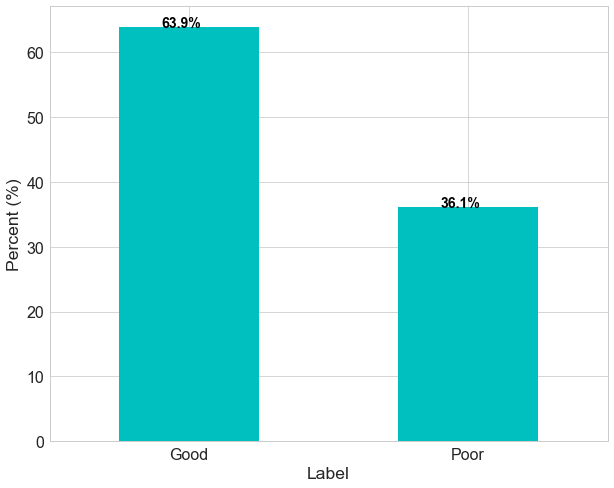

In [100]:
rev_score=(df_ml.label.value_counts(normalize=True).sort_index()*100)

# Define a function to plot bars with annotation; s: a series, rot: rotation of xtick labels; xlab: xlabels
def plot_bar(s,xlab,rot=0):
    ax=s.plot(kind='bar',rot=rot,color='c')
    for i, v in enumerate(s):
        ax.text( i-0.1,v , str(round(v,1))+'%', color='black', fontweight='bold',fontsize=14)
    plt.xlabel(xlab)
    plt.ylabel('Percent (%)');
    
plot_bar(rev_score,'Label',0)

In [102]:
# Use the bag-of-words features for binary classification
lab_bin=LabelBinarizer()
y=lab_bin.fit_transform(df_ml['label'])

X_train, X_test, y_train, y_test = train_test_split(df_ml['Rev_Lemmatized'], y,test_size=0.3,
    random_state=100)

bow_steps_bin=[('vectorise',CountVectorizer(
                                        min_df=10,
                                        stop_words='english',
                                        token_pattern='[a-zA-Z]{3,}')),
         ('clf',MultinomialNB())]

bow_pipe_bin,bow_training_accuracy_bin, bow_test_accuracy_bin, bow_conf_mtrix_bin, bow_class_report_bin=run_pipeline(bow_steps_bin,X_train,y_train,X_test,y_test)



Accuracy of training set: 0.78
Accuracy of test set: 0.78

Confusion Matrix:
 [[69757 12835]
 [15755 30493]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.82      0.84      0.83     82592
          1       0.70      0.66      0.68     46248

avg / total       0.78      0.78      0.78    128840



## Enrich Predictors with Categorical and Numerical Features
We extract categorical columns and numerical columns and fill missing values in categorical columns with 'None'. We impute missing values in numerical features by its median. Then split the data into training and test set.

In [103]:
col_categories=['Review_Month', 'Hotel_City', 'Trip_Type','Traveler_Type']
df_ml.Trip_Type.fillna('None',inplace=True)

col_num=['Total_Number_of_Reviews_Reviewer_Has_Given','Review_Total_Positive_Word_Counts',
          'Review_Total_Negative_Word_Counts','Num_Nights']

X=df_ml[col_categories+col_num+['Rev_Lemmatized']]
y=lab_bin.fit_transform(df_ml['label'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,test_size=0.3,random_state=100)

Use the FunctionTransformer to create an object out of a Python function that help select subsets of data in a way that plays nicely with pipelines.

In [104]:
get_text_data=FunctionTransformer(lambda x: x['Rev_Lemmatized'],validate=False)
get_num_data=FunctionTransformer(lambda x: x[col_num],validate=False)
get_cat_data=FunctionTransformer(lambda x: pd.get_dummies(x[col_categories]),validate=False)

# Build text pipeline
text_pipeline=Pipeline([('selector', get_text_data ),
                        ('vectorise',TfidfVectorizer(
                                        min_df=10,
                                        ngram_range=(1,2),
                                        stop_words='english',
                                        token_pattern='[a-zA-Z]{3,}')),
                       #('dim_red',SelectKBest(chi2,k=5000))
                       ])
# Build cat pipeline
cat_pipeline=Pipeline([('selector',get_cat_data),
                        #('interact',PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)),#doesn't work with sparse matrix                      
                      ])

# Build num pipeline
num_pipeline=Pipeline([('selector',get_num_data),
                        ('imputer',Imputer(strategy='median')),
                       ('interact',PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)),               
                       ('scaler',MinMaxScaler()),
                      ])

# Union numeric and text features
union=FeatureUnion([('cat',cat_pipeline),('num',num_pipeline),('text',text_pipeline)])




In [105]:
steps_NB_bin=[
    ('union',FeatureUnion([('cat',cat_pipeline),('num',num_pipeline),('text',text_pipeline)])),
    #('interact',PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)),#doesn't work with sparse matrix
    #('interact',SparseInteractions(degree=2)),#takes time but didn't improve significantly
    #https://gist.github.com/pjbull/063a9b4e4f9cfcc4d03cba18fee63de7
    ('clf',MultinomialNB())
    ]
res_NB_bin=run_pipeline(steps_NB_bin,X_train,y_train,X_test,y_test)
NB_training_accuracy=res_NB_bin[1]
NB_test_accuracy=res_NB_bin[2]
NB_conf_mtrix=res_NB_bin[3]
NB_class_report=res_NB_bin[4]


pickle.dump(NB_training_accuracy, open('save/Tfidf_NB_training_accuracy.sav', 'wb'))
pickle.dump(NB_test_accuracy, open('save/Tfidf_NB_test_accuracy.sav', 'wb'))
pickle.dump(NB_conf_mtrix, open('save/Tfidf_NB_conf_mtrix.sav', 'wb'))
pickle.dump(NB_class_report, open('save/Tfidf_NB_class_report.sav', 'wb'))


Accuracy of training set: 0.81
Accuracy of test set: 0.79

Confusion Matrix:
 [[72396 10196]
 [16746 29502]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.81      0.88      0.84     82592
          1       0.74      0.64      0.69     46248

avg / total       0.79      0.79      0.79    128840



In [106]:
steps_LR_bin=[
    ('union',FeatureUnion([('cat',cat_pipeline),('num',num_pipeline),('text',text_pipeline)])),
    #('interact',PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)),#doesn't work with sparse matrix
    #('interact',SparseInteractions(degree=2)),#takes time but didn't improve significantly
    #https://gist.github.com/pjbull/063a9b4e4f9cfcc4d03cba18fee63de7
    
    ('clf',LogisticRegression())
]

res_LR_bin=run_pipeline(steps_LR_bin,X_train,y_train,X_test,y_test)

LR_training_accuracy=res_LR_bin[1]
LR_test_accuracy=res_LR_bin[2]
LR_conf_mtrix=res_LR_bin[3]
LR_class_report=res_LR_bin[4]



pickle.dump(LR_training_accuracy, open('save/Tfidf_LR_training_accuracy.sav', 'wb'))
pickle.dump(LR_test_accuracy, open('save/Tfidf_LR_test_accuracy.sav', 'wb'))
pickle.dump(LR_conf_mtrix, open('save/Tfidf_LR_conf_mtrix.sav', 'wb'))
pickle.dump(LR_class_report, open('save/Tfidf_LR_class_report.sav', 'wb'))



Accuracy of training set: 0.84
Accuracy of test set: 0.81

Confusion Matrix:
 [[72633  9959]
 [14568 31680]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.83      0.88      0.86     82592
          1       0.76      0.69      0.72     46248

avg / total       0.81      0.81      0.81    128840



In [107]:
steps_RF_bin=[
    ('union',FeatureUnion([('cat',cat_pipeline),('num',num_pipeline),('text',text_pipeline)])),
    #('interact',PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)),#doesn't work with sparse matrix
    #('interact',SparseInteractions(degree=2)),#takes time but didn't improve significantly
    #https://gist.github.com/pjbull/063a9b4e4f9cfcc4d03cba18fee63de7
    
    ('clf',RandomForestClassifier())
]

res_RF_bin=run_pipeline(steps_RF_bin,X_train,y_train,X_test,y_test)

RF_training_accuracy=res_RF_bin[1]
RF_test_accuracy=res_RF_bin[2]
RF_conf_mtrix=res_RF_bin[3]
RF_class_report=res_RF_bin[4]



pickle.dump(RF_training_accuracy, open('save/Tfidf_RF_training_accuracy.sav', 'wb'))
pickle.dump(RF_test_accuracy, open('save/Tfidf_RF_test_accuracy.sav', 'wb'))
pickle.dump(RF_conf_mtrix, open('save/Tfidf_RF_conf_mtrix.sav', 'wb'))
pickle.dump(RF_class_report, open('save/Tfidf_RF_class_report.sav', 'wb'))




Accuracy of training set: 0.98
Accuracy of test set: 0.77

Confusion Matrix:
 [[74504  8088]
 [22064 24184]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.77      0.90      0.83     82592
          1       0.75      0.52      0.62     46248

avg / total       0.76      0.77      0.75    128840



In [108]:
steps_SVC_bin=[
    ('union',FeatureUnion([('cat',cat_pipeline),('num',num_pipeline),('text',text_pipeline)])),
    #('interact',PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)),#doesn't work with sparse matrix
    #('interact',SparseInteractions(degree=2)),#takes time but didn't improve significantly
    #https://gist.github.com/pjbull/063a9b4e4f9cfcc4d03cba18fee63de7
    
    ('clf',LinearSVC())
]

res_SVC_bin=run_pipeline(steps_SVC_bin,X_train,y_train,X_test,y_test)

SVC_training_accuracy=res_SVC_bin[1]
SVC_test_accuracy=res_SVC_bin[2]
SVC_conf_mtrix=res_SVC_bin[3]
SVC_class_report=res_SVC_bin[4]



pickle.dump(SVC_training_accuracy, open('save/Tfidf_SVC_training_accuracy.sav', 'wb'))
pickle.dump(SVC_test_accuracy, open('save/Tfidf_SVC_test_accuracy.sav', 'wb'))
pickle.dump(SVC_conf_mtrix, open('save/Tfidf_SVC_conf_mtrix.sav', 'wb'))
pickle.dump(SVC_class_report, open('save/Tfidf_SVC_class_report.sav', 'wb'))



Accuracy of training set: 0.88
Accuracy of test set: 0.79

Confusion Matrix:
 [[70754 11838]
 [14990 31258]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.83      0.86      0.84     82592
          1       0.73      0.68      0.70     46248

avg / total       0.79      0.79      0.79    128840



In [109]:
steps_SGD_bin=[
    ('union',FeatureUnion([('cat',cat_pipeline),('num',num_pipeline),('text',text_pipeline)])),
    #('interact',PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)),#doesn't work with sparse matrix
    #('interact',SparseInteractions(degree=2)),#takes time but didn't improve significantly
    #https://gist.github.com/pjbull/063a9b4e4f9cfcc4d03cba18fee63de7
    
    ('clf',SGDClassifier())
]

res_SGD_bin=run_pipeline(steps_SGD_bin,X_train,y_train,X_test,y_test)

SGD_training_accuracy=res_SGD_bin[1]
SGD_test_accuracy=res_SGD_bin[2]
SGD_conf_mtrix=res_SGD_bin[3]
SGD_class_report=res_SGD_bin[4]



pickle.dump(SGD_training_accuracy, open('save/Tfidf_SGD_training_accuracy.sav', 'wb'))
pickle.dump(SGD_test_accuracy, open('save/Tfidf_SGD_test_accuracy.sav', 'wb'))
pickle.dump(SGD_conf_mtrix, open('save/Tfidf_SGD_conf_mtrix.sav', 'wb'))
pickle.dump(SGD_class_report, open('save/Tfidf_SGD_class_report.sav', 'wb'))



Accuracy of training set: 0.81
Accuracy of test set: 0.80

Confusion Matrix:
 [[72865  9727]
 [15590 30658]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.82      0.88      0.85     82592
          1       0.76      0.66      0.71     46248

avg / total       0.80      0.80      0.80    128840



### Improved Model Performance

In [110]:
# Accuracy score of the training and test set for each model
model_FeatUnion_accuracy={
                'bow_text':bow_test_accuracy_bin,
                'Tfidf_Featunion_NB':NB_test_accuracy,
                'Tfidf_Featunion_LR':LR_test_accuracy,
                'Tfidf_Featunion_RF':RF_test_accuracy,
                'Tfidf_Featunion_SVC':SVC_test_accuracy,
                'Tfidf_Featunion_SGD':SGD_test_accuracy,}
model_FeatUnion_performance=pd.DataFrame.from_dict(model_FeatUnion_accuracy,orient='index')
model_FeatUnion_performance.columns=['test_accuracy']
np.round(model_FeatUnion_performance,2)#.T

,test_accuracy
bow_text,0.78
Tfidf_Featunion_NB,0.79
Tfidf_Featunion_LR,0.81
Tfidf_Featunion_RF,0.77
Tfidf_Featunion_SVC,0.79
Tfidf_Featunion_SGD,0.80


In [111]:

# Print classification report
print('bow_text: \n')
print(bow_class_report_bin)

print('Tfidf_Featunion_NB: \n')
print(NB_class_report)

print('Tfidf_Featunion_LR: \n')
print(LR_class_report)

print('Tfidf_Featunion_RF: \n')
print(RF_class_report)


print('Tfidf_Featunion_SVC: \n')
print(SVC_class_report)

print('Tfidf_Featunion_SGD: \n')
print(SGD_class_report)


bow_text: 

             precision    recall  f1-score   support

          0       0.82      0.84      0.83     82592
          1       0.70      0.66      0.68     46248

avg / total       0.78      0.78      0.78    128840

Tfidf_Featunion_NB: 

             precision    recall  f1-score   support

          0       0.81      0.88      0.84     82592
          1       0.74      0.64      0.69     46248

avg / total       0.79      0.79      0.79    128840

Tfidf_Featunion_LR: 

             precision    recall  f1-score   support

          0       0.83      0.88      0.86     82592
          1       0.76      0.69      0.72     46248

avg / total       0.81      0.81      0.81    128840

Tfidf_Featunion_RF: 

             precision    recall  f1-score   support

          0       0.77      0.90      0.83     82592
          1       0.75      0.52      0.62     46248

avg / total       0.76      0.77      0.75    128840

Tfidf_Featunion_SVC: 

             precision    recall  f1-sc